# Large Disaster Forecast: Can Census Inform County Level Projections
There are a series of challenges with forecasting the number of registrations received using publically available data. Two will be analyzed here. First, this analysis attempts to predict the number of registrations by US-County. The second challenge is related to the variance in the data. If we can sub-divide the data into smaller groups, is there a way to predict which group each county will be assigned.  

Questions:
1. Are **Female heads of households**, **households with people with disabilities**, **households with elderly people**, **working individuals** or **SNAP Recipients** good indicators of the number of registrations received by a county in a disaster?
2. Is there a meaningful way to sub-divide the data to reduce the variance?
3. Is there a relationship between the geographic characteristics of a county and the number of registrations received?
4. Can we find model to classify the counties into the sub-divided groups?
5. How can we use the number of registrations per household to help make predictions about the disaster?

> This tool uses open source FEMA and Census data to investigate relationships between family types and size with disaster registrations. The datasets included in this forecast are the Census S2201 Subject Table and two FEMA tables--one for summary information and the other for Individual Assistance Registration counts. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from datetime import datetime,timedelta
import requests
from io import BytesIO, StringIO
import seaborn as sns


import warnings
warnings.simplefilter(action = 'ignore',category = FutureWarning)
warnings.simplefilter(action = 'ignore',category = RuntimeWarning)
# warnings.simplefilter(action = 'ignore',category = SettingWithCopyWarning)



# Census API Key: Hashed
yourKeyGoesHere = '9d14124eea832221aed405df89e622b1e889aad6'

#NOAA Token
noaaToken = r'JclKoFPahRVySupyHoVYfYLUnZNzawSn'

#Output the last script runtime
scriptBegin = datetime.now()
print(f'The script was last run on {scriptBegin}')
year = scriptBegin.year


The script was last run on 2023-01-19 06:38:59.971386


In [2]:
#Import Machine Learning Libraries: skLearn and StatsModel
from sklearn.preprocessing import StandardScaler
from sklearn.impute import  KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import  mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, recall_score,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestRegressor as RFR, RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.cluster import KMeans

import statsmodels.api as sm

In [3]:
#Create a Range of years using Current Year date to enhance repeatability
min_year = 2016
max_year = year
max_census = 2021
# projection_type = 'Severe Storm'

# Functions
1. FEMA API Call
2. Census API Call S2201
3. Census dataframe conversion
4. Census Datatype conversions

## Function 1: Get FEMA Data from the FEMA API

In [4]:
def get_fema_data(url):
    '''
    Context: The purpose of this function is to generalize the connection to the FEMA API.
             The function accepts the url listed on the website and then adds a json extension.
             The json extension converts the data to a dictionary and then filters the keys for
             the most current data. Not all of the data structures are the same, so if the values
             to reduce the size of the dataset are available, the try and except clause attempts
             to reduce the values looped-in. 
             
    Args:   FEMA url for the api connection
    Output: Dataframe of the FEMA API
    '''
    
    #Convert the url of the data location to the 
    _url = f'{url}.json'
    
    #Use the requests library to get the URL and convert to JSON
    response = requests.get(_url) 
    response_json = response.json()
    
    #Create a loop that accesses the json values
    _data = []
    for key, value in response_json.items():
        #Convert to a dataframe using the DataFrame from dict function
        data = pd.DataFrame.from_dict(value)
        #Filter the Disaster Numbers between 4000 and 5000
        data = data[(data['disasterNumber'].astype(int)>=4000)\
                   &(data['disasterNumber'].astype(int)<5000)]
        
        try:
            # Filter data by dropping unnecessary columns
            data = data[data['declarationType']=='DR']
            data = data.drop(['paProgramDeclared','hmProgramDeclared'], axis = 1)
            data = data.drop(['hash','id'], axis = 1)
            data = data.drop(['lastIAFilingDate'], axis = 1)
            data = data.drop(['lastRefresh'], axis = 1)
            data = data.drop(['zipCode','city'], axis = 1)
        except Exception as e:
            pass
        #Append the data to the instantiated variable data
        _data.append(data)
    
    #Convert to a dataframe and reset the index and return the dataframe
    _df = pd.DataFrame(pd.concat(_data, sort = False)).reset_index(drop = True)
    return _df
                       

## Function 2: Census Dataframe Conversion
* Converts the json read in by the api call into a dataframe. 

In [5]:
def json_to_dataframe(response):
    '''
    Convert response variable to dataframe
    '''
    return(pd.DataFrame(response.json()[1:],columns= response.json()[0]))

## Function 3: Generalizable Census API call
* Currently designed to access county level data
* Commented code can be modified using the same inputs to access tract level data

In [6]:
def census_county_detail(year, st_cd, table, elements, yourKeyGoesHere):
    '''
    Context: The purpose of this function is to generalize the connection to the Census api.
             Although Census has libraries this method is more generalizable to all api calls.
             This method calls on all of the county values (see for=county:*), but could be 
             used for Census Tract or Block values. Instantiating this function in a loop
             reduces the likelihood that the user will exceed the 'reasonable' amount of data
             that can be downloaded at any one time.
             
    Args:  
         - year:            This is the year derived from the range of years investigated range(min_year,max_year)
         - st_cd:           The fips state code number derived from the range of 1-72. Census requires a two
                            digit state number listed as a string. This is modified in the loop by adding a zero
                            and converting the value to a string
         - Table:           This is the type of Census table requested. Common Types are Profile and Subject
         - elements:        Census values to be read-in. They can be individual values or entire tables
         - yourKeyGoesHere: Census API Key. Must be requested from Census
                     
    
    Output: List created through the append statement of dataframes from the api call and years called
    '''
    # Creates a path for the requests library to call on the Subject and Group tables
    countyLvlData = f'https://api.census.gov/data/{year}/acs/acs5/{table}?get={elements}&for=county:*&in=state:{st_cd}&key={yourKeyGoesHere}'
    respCountylvl = requests.get(countyLvlData)
    
    try:
        
        #Convert to dataframe and add a year
        data = json_to_dataframe(respCountylvl)
        data['year'] = year 

        #Append the data to the dataframe variable in the loop
        dataframe.append(data)
        
    #Error will print if state numerical code not represented in database (e.g. Alabama = 01, Puerto Rico = 72)
    #This is useful to ensure max tries was not reached and the API call is working appropriately
    except Exception as error:
        raise
        print(year,st_cd,error)

    

## Function 4: Cenus Features and Data Types:
1. Creates a GEOID to create a simple key for later joins
2. Converts numerical values to floating point numbers.
3. Skips important variable character strings

In [7]:
def datatypeconv(dataframe):
    '''
    Context: The purpose of this function is to add a key called GEOID for later joins and
             convert the data types of the numerical census values from objects to floating
             point numbers. 
             
    Args:   Census dataframe created by API call
    Output: Census dataframe created by API call with object types converted to floating point numbers
    '''
    
    #Create a key to make it easier to join the gazateer data
    dataframe['GEOID'] = dataframe['state']+ dataframe['county']
    
   #Convert the data
    for columnName in dataframe.columns:
        try:
            if columnName in  ['state','county','GEOID']:
                pass
            else:
                dataframe[columnName] = dataframe[columnName].astype(float)
        except Exception as e:
            print(e)
        
    return dataframe

In [8]:
def community_impact(s2201_variable,target_variable):
    '''
    Context: The purpose of this function is to visually inspect the regplots for the subdivided data  
    
    Args:   Census element of interest
    
    Output: Spearman Correlation and Compiled Regplot with the for all the communityImpact levels
    '''
    plt.xlabel(s2201_variable)
    plt.ylabel(target_variable)
    for dr_size in dfIncidentType['communityImpact'].unique():
        dfx = dfIncidentType[dfIncidentType['communityImpact'].isin([dr_size])]
        S_corr = dfx[[f'{s2201_variable}',f'{target_variable}']].corr(method = 'spearman').values[0][1]
        
        #Print the Spearman Correlation. Data is Skewed
        print('{} Community Impact: Spearman Correlation {:.2f}'.format(dr_size,S_corr))
        
        #View the Regplot of the variable to total valid registrations
        sns.regplot(np.log([x+1 for x in dfx[f'{s2201_variable}']])
                   ,np.log([x+1 for x in dfx[f'{target_variable}']])
                   )
                      

In [9]:
def noaa_water(token, GEOID, incidentBeginDate, incidentDatePlus):
    '''
    Context: This data is generated from an api call to the NOAA Precipitation information. The goal
             Is to find a proxy for the community Impact element. The goal is to reduce subjectivity
             in the Counties projected and the size of the disaster. 
   
    Args:   
          - GEOID:             This is also known as the fips code. First two numbers are the codes 
                               representing each state (AL = 01) and the last three digits are the 
                               county values within each state.     
          - incidentBeginDate: The date of the FEMA Declared Incident
          - incidentDatePlus5: Five Day forecasts are common early in a disaster. This feature creates
                               an end date for the water values to be tallied. 
   
    Output: This function outputs a grouped dataframe with the NOAA data by fips code. 
            The Fips Code and incident begin dates are added for a later join.
    '''
    
    url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&units=metric&locationid=FIPS:{GEOID}&startdate={incidentBeginDate}&enddate={incidentDatePlus}'

    #Assign the token to the requests call
    header = {"token":token}
    response = requests.get(url,headers = header)
    #convert the request call to json
    noaaResponse = response.json()
    
    dataset = []
    #Convert the json to a dictionary and unnest the json
    for key,value in noaaResponse.items():
        for items in value:
            #This is the outer value. must be excluded for a dataframe conversion
            if 'resultset' in items:
                continue
            else:
                #Convert the items iterator to a dataframe and Transpose the data
                data = items
                data = pd.DataFrame.from_dict(data, orient = 'index').T
                #This is called Fips code for context: Key for Join
                data['Fips Code'] = GEOID
                #Assign the incidentBegin date back to the transformed data: Key for Join
                data['incidentBeginDate'] = incidentBeginDate
                dataset.append(data)
    
    #Concatenate the data and then group the dataframe before it is outputted
    dfNoaa = pd.DataFrame(pd.concat(dataset, sort = False))
    #Drop unnessary Columns
    #dfNoaa = dfNoaa.drop(['date','datatype','station','attributes'], axis = 1)
    dfNoaa = dfNoaa.drop(['date','station','attributes'], axis = 1)
    #Converted for performance: The average Precipitation Rates gives a better classification forecast
    dfNoaa = dfNoaa.groupby(['Fips Code','incidentBeginDate','datatype']).mean().reset_index()
    #Remove the double leveled index and rename the columns
    #dfNoaa = dfNoaa.reset_index()
    dfNoaa.columns = ['GEOID','incidentBeginDate','datatype','Totals']
    
    #Append the data for a larger dataframe conversion
    #noaa_data.append(dfNoaa)
    return dfNoaa


# 1. Data Gathering: Census Loop
>This loop uses the above function (census_county_detail) to ingest data from the Census API. 

In [10]:
#This is the tables used for the census call
Table = 'subject'
elements = 'group(S2201)'

dataframe = []
#The nested for loop allows for a year parameter to be called 
for year in range(min_year,max_year):
    print(year)
     #This calls on the state codes listed as numerical values
    for st_cd in range(1,73):
        
        try:
            #Range as an int, Census requires a two digit string
            #if st_cd in range(1,10):
            st_cd = str(st_cd).zfill(2)
            #Variables in this function are explained in f(x) above
            census_county_detail(
                                  year=year
                                 ,st_cd = st_cd
                                 ,elements = elements
                                 ,table = Table
                                 ,yourKeyGoesHere=yourKeyGoesHere
                                )
            
#             else:
#                 st_cd = str(st_cd)
#                 census_county_detail(
#                                       year=year
#                                      ,st_cd = st_cd
#                                      ,elements = elements
#                                      ,table = Table
#                                      ,yourKeyGoesHere=yourKeyGoesHere
#                                     )

        except Exception as e:
            continue

df_census = pd.DataFrame(pd.concat(dataframe, sort = False))
print('complete')

df_census.tail()

2016
2017
2018
2019
2020
2021
2022
complete


GEO_ID                              NAME S2201_C01_001E  \
73  0500000US72145  Vega Baja Municipio, Puerto Rico          19799   
74  0500000US72147    Vieques Municipio, Puerto Rico           2374   
75  0500000US72149   Villalba Municipio, Puerto Rico           7823   
76  0500000US72151    Yabucoa Municipio, Puerto Rico          11905   
77  0500000US72153      Yauco Municipio, Puerto Rico          11836   

   S2201_C01_001EA S2201_C01_001M S2201_C01_001MA S2201_C01_002E  \
73            None            451            None          10205   
74            None            293            None           1402   
75            None            313            None           4000   
76            None            390            None           6285   
77            None            379            None           6961   

   S2201_C01_002EA S2201_C01_002M S2201_C01_002MA  ... S2201_C06_037EA  \
73            None            344            None  ...            None   
74            None            227            None  ...            None   
75            None            229            None  ...            None   
76            None            288            None  ...            None   
77            None            286            None  ...            None   

   S2201_C06_037M S2201_C06_037MA S2201_C06_038E S2201_C06_038EA  \
73            3.9            None           29.0            None   
74           15.7            None           10.1            None   
75            7.8            None           33.7            None   
76            6.0            None           37.0            None   
77            5.7            None           28.8            None   

   S2201_C06_038M S2201_C06_038MA state county  year  
73            3.3            None    72    145  2021  
74            9.6            None    72    147  2021  
75            7.5            None    72    149  2021  
76            6.7            None    72    151  2021  
77            5.1            None    72    153  2021  

[5 rows x 917 columns]

## When Reading in the Data from the Census API:
* MOE and Percentages must be removed
    1. MOE unnecessary for our efforts
    2. Percentages can be created by dividing by Number of Households S2201_C01_001E

In [11]:
#Remove Margin of Error and replace special characters
print('start')
for column_name in df_census.columns:
    #This reduces performance in the shortrun, but reduces the amount of data managed in the longrun
    if column_name[-1]=='M' or column_name[-2:]=='MA'\
    or column_name[-2:]=='EA' or column_name[-2:]=='PE':
        df_census.drop(column_name, axis = 1, inplace = True)
        #print(column_name, 'MOE/Annotation Removed')
        
    #Percentages are removed:
    #Percentages can be created by dividing by the number of households ['S2201_C01_001E']
    elif 'C02' in column_name[6:9] or 'C04'in column_name[6:9] or 'C06' in column_name[6:9]:
        df_census.drop(column_name, axis = 1, inplace = True)
        #print(column_name, 'Percentages Removed')
print('complete')        

start
complete


In [12]:
#Make a copy of the df_census Dataframe and reset the index
dfCensus = df_census.copy()
dfCensus.reset_index(drop = True, inplace = True)

#Convert the datatypes
#Data is read in as an object. This function converts all numerical values
dfcensus = datatypeconv(dfCensus)

dfcensus.head()

could not convert string to float: '0500000US01099'
could not convert string to float: 'Monroe County, Alabama'


GEO_ID                      NAME  S2201_C01_001E  S2201_C01_002E  \
0  0500000US01099    Monroe County, Alabama          8316.0          3447.0   
1  0500000US01079  Lawrence County, Alabama         13321.0          5198.0   
2  0500000US01081       Lee County, Alabama         57901.0         16256.0   
3  0500000US01093    Marion County, Alabama         12486.0          5577.0   
4  0500000US01107   Pickens County, Alabama          7618.0          3305.0   

   S2201_C01_003E  S2201_C01_004E  S2201_C01_005E  S2201_C01_006E  \
0          4869.0          3655.0          1502.0           422.0   
1          8123.0          7230.0          2226.0           670.0   
2         41645.0         25640.0         10678.0          2430.0   
3          6909.0          6802.0          2130.0           509.0   
4          4313.0          3317.0          1483.0           411.0   

   S2201_C01_007E  S2201_C01_008E  ...  S2201_C05_033E  S2201_C05_034E  \
0          1080.0          3159.0  ...          4341.0         34347.0   
1          1556.0          3865.0  ...          8656.0         50079.0   
2          8248.0         21583.0  ...         37249.0         50247.0   
3          1621.0          3554.0  ...          9701.0         40586.0   
4          1072.0          2818.0  ...          4007.0         39128.0   

   S2201_C05_035E  S2201_C05_036E  S2201_C05_037E  S2201_C05_038E  state  \
0          4300.0          1324.0          1478.0          1498.0     01   
1          7868.0          1489.0          3045.0          3334.0     01   
2         31115.0          4028.0          9593.0         17494.0     01   
3          7431.0          1542.0          2268.0          3621.0     01   
4          3923.0           891.0          1174.0          1858.0     01   

   county    year  GEOID  
0     099  2016.0  01099  
1     079  2016.0  01079  
2     081  2016.0  01081  
3     093  2016.0  01093  
4     107  2016.0  01107  

[5 rows x 120 columns]

In [13]:
print('Number of Census columns in the dataset: ',len(dfCensus.columns))

Number of Census columns in the dataset:  120


In [14]:
## TESTING ##
#This dataset has 120 columns after intial cleaning complete. Use while loop to look at datatypes and nulls 
# n = 0
# i = 15
# while i <= len(dfCensus.columns):
#     print(i)
#     dfcensus.iloc[:,n:i].info()
#     n+=15
#     i+=15

## This is Additional Metadata from Census
* Area Square Miles
* Water Square Miles
* County information 


In [15]:
# https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2022_Gazetteer/2022_Gaz_counties_national.zip #
gazetteer = []

#This loop accesses the many years of Census Gazetteer data for a join. 
 #It contains information about the geographic characteristics of the counties
for yr in range(min_year,max_year):
    try:
        #Read in each year's worth of data
        g_url = f'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/{yr}_Gazetteer/{yr}_Gaz_counties_national.zip'
        #Use requests library to mke call
        resp = requests.get(g_url)
        #print(resp.status_code)
        #print(g_url)
        #Convert the Zipfile call to Bytes
        zipfile = ZipFile(BytesIO(resp.content))
        #Unnest the Zip file and read in the data
        for file in zipfile.namelist():
            data = pd.read_csv(zipfile.open(file,'r'), sep = '\t'
                               ,encoding_errors= 'replace'
                               ,dtype = {'GEOID':str}
                              )
            data['year'] = str(yr)
            data['st_cd'] = data['GEOID'].str.slice(start = 0, stop = 2)
            data['Fips_county'] = data['GEOID'].str.slice(start  = 2, stop = 6 )
            gazetteer.append(data)
    except Exception as e:
        print(resp.status_code,g_url,e)
                
df_gaz = pd.DataFrame(pd.concat(gazetteer,sort = False))
df_gaz.head()

USPS  GEOID  ANSICODE            NAME       ALAND      AWATER  ALAND_SQMI  \
0   AL  01001    161526  Autauga County  1539609015    25749942     594.446   
1   AL  01003    161527  Baldwin County  4117584019  1133130502    1589.808   
2   AL  01005    161528  Barbour County  2291818680    50864677     884.876   
3   AL  01007    161529     Bibb County  1612481559     9287974     622.583   
4   AL  01009    161530   Blount County  1670041875    15077458     644.807   

   AWATER_SQMI   INTPTLAT  \
0        9.942  32.532237   
1      437.504  30.659218   
2       19.639  31.870253   
3        3.586  33.015893   
4        5.821  33.977358   

   INTPTLONG                                                                                                                 \
0                                         -86.646440                                                                          
1                                         -87.746067                                                                          
2                                         -85.405104                                                                          
3                                         -87.127148                                                                          
4                                         -86.566440                                                                          

   year st_cd Fips_county  
0  2016    01         001  
1  2016    01         003  
2  2016    01         005  
3  2016    01         007  
4  2016    01         009

In [16]:
# Rename the columns
df_gaz.columns = ['USPS','GEOID','ANSICODE','NAME'
                  ,'ALAND','AWATER','ALAND_SQMI'
                  ,'AWATER_SQMI','INTPTLAT','INTPTLONG','year'
                  ,'st_cd','Fips_county'
                 ]


## 1. Data Gathering: FEMA DATA

In [17]:
#Call on the Summary table from the API
summary_url = r'https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries'
summary_df = get_fema_data(summary_url)

#Call on the Summary table from the API
url4 = r'https://www.fema.gov/api/open/v2/RegistrationIntakeIndividualsHouseholdPrograms'
fema_df = get_fema_data(url4)

#Group the data by disaster, state and county to aggregate the values in the dataframe
fema_df = fema_df.groupby(['disasterNumber','state','county']).sum()

#Reset the index to eliminate the multi-index
#Drop set to false to keep the indexed columns
fema_df = fema_df.reset_index()

#Join the Summary and county datasets
df_fema = pd.merge(fema_df,summary_df
                   ,left_on = ['disasterNumber','state','county']
                   ,right_on = ['disasterNumber','state','designatedArea']
                   ,how = 'left'
                   ,suffixes = ['_summary','_county'] 
                  )
#Assign the year for a futue join. 
df_fema['declarationDate'] = pd.to_datetime(df_fema['declarationDate'])
df_fema['yr'] = df_fema['declarationDate'].dt.year
df_fema['year'] = df_fema['yr'].astype(str).str.replace('2022.0','2021.0')

#Filter the Number of years from 2016 forward
df_fema = df_fema[(df_fema['yr']>=min_year)
                 # &(df_fema['yr']<2022)
                 ].reset_index(drop=True)
# df_fema = df_fema[df_fema['totalValidRegistrations']>10].reset_index(drop = True)
#Inspect the data
df_fema.tail()

disasterNumber state              county  totalValidRegistrations  \
4719            4680    FL    Flagler (County)                      356   
4720            4680    FL       Lake (County)                      295   
4721            4680    FL     Putnam (County)                      206   
4722            4680    FL  St. Johns (County)                      189   
4723            4680    FL    Volusia (County)                     2372   

      validCallCenterRegistrations  validWebRegistrations  \
4719                           113                    111   
4720                            61                     87   
4721                            45                     41   
4722                            49                     63   
4723                           550                    696   

      validMobileRegistrations  ihpReferrals  ihpEligible   ihpAmount  ...  \
4719                       132           257           76   284772.11  ...   
4720                       147           154           22    61085.61  ...   
4721                       120           116           36    86987.80  ...   
4722                        77           132           27    81311.91  ...   
4723                      1126          1573          441  1531191.23  ...   

             incidentBeginDate           incidentEndDate  \
4719  2022-11-07T00:00:00.000Z  2022-11-30T00:00:00.000Z   
4720  2022-11-07T00:00:00.000Z  2022-11-30T00:00:00.000Z   
4721  2022-11-07T00:00:00.000Z  2022-11-30T00:00:00.000Z   
4722  2022-11-07T00:00:00.000Z  2022-11-30T00:00:00.000Z   
4723  2022-11-07T00:00:00.000Z  2022-11-30T00:00:00.000Z   

      disasterCloseoutDate  fipsStateCode  fipsCountyCode  placeCode  \
4719                  None             12             035      99035   
4720                  None             12             069      99069   
4721                  None             12             107      99107   
4722                  None             12             109      99109   
4723                  None             12             127      99127   

          designatedArea declarationRequestNumber      yr    year  
4719    Flagler (County)                    22104  2022.0  2021.0  
4720       Lake (County)                    22104  2022.0  2021.0  
4721     Putnam (County)                    22104  2022.0  2021.0  
4722  St. Johns (County)                    22104  2022.0  2021.0  
4723    Volusia (County)                    22104  2022.0  2021.0  

[5 rows x 34 columns]

# 2. Data Understanding

<AxesSubplot:>

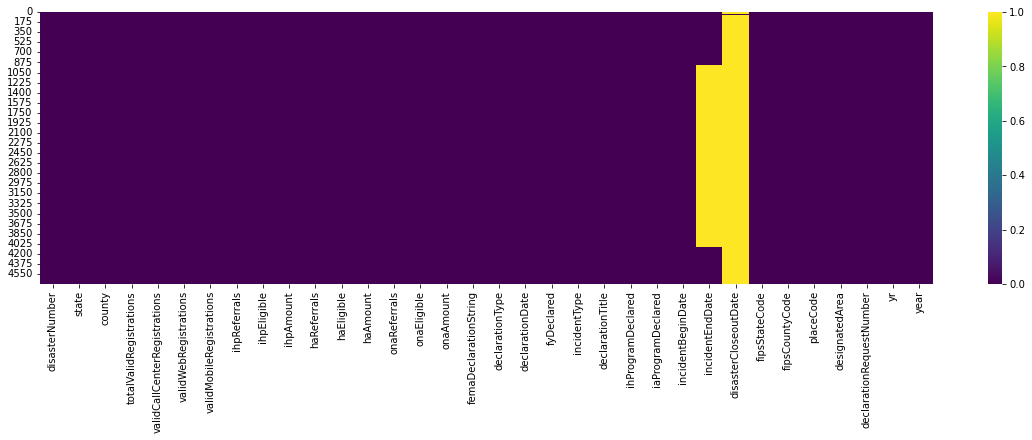

In [18]:
# Use the heatmap to see if there are columns to drop
plt.figure(figsize = [20,5])
sns.heatmap(df_fema.isnull(),cmap = 'viridis')

In [19]:

#Convert the year to a string for merging later
df_fema.year = df_fema.year.astype(float).astype(int).astype(str)

#Drop mostly null elements
df_fema.drop(['incidentEndDate','disasterCloseoutDate'], axis = 1, inplace = True)

#Convert Declaration Date to a datetime type and add a year column to join in the next step
df_fema['incidentBeginDate'] = pd.to_datetime(df_fema['incidentBeginDate'])
df_fema['Number of Days'] = df_fema['declarationDate'] - df_fema['incidentBeginDate']

#Assign the number of days for future modeling
df_fema['Number of Days'] = df_fema['Number of Days'].dt.days 

#Investigate additional Null values
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   disasterNumber                4724 non-null   int64              
 1   state                         4724 non-null   object             
 2   county                        4724 non-null   object             
 3   totalValidRegistrations       4724 non-null   int64              
 4   validCallCenterRegistrations  4724 non-null   int64              
 5   validWebRegistrations         4724 non-null   int64              
 6   validMobileRegistrations      4724 non-null   int64              
 7   ihpReferrals                  4724 non-null   int64              
 8   ihpEligible                   4724 non-null   int64              
 9   ihpAmount                     4724 non-null   float64            
 10  haReferrals                   4724 n

In [20]:
df_fema.disasterNumber.nunique()


180

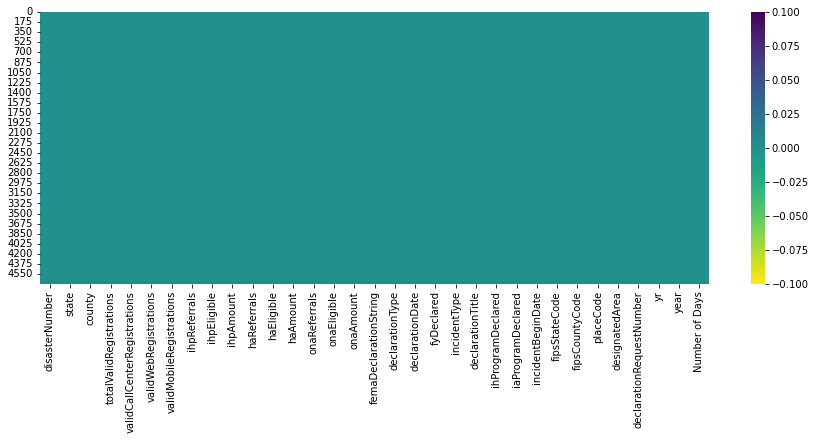

In [21]:
#Visually inspect the nulls
plt.figure(figsize = [15,5])
sns.heatmap(df_fema.isnull(), cmap = 'viridis_r');

In [22]:
#Create a GEOID column to make joining easier in th next step
df_fema['GEOID'] = df_fema['fipsStateCode'] + df_fema['fipsCountyCode'] 

df_fema.reset_index(inplace = True, drop = True)

In [23]:
df_gaz['yr'] = df_gaz['year'].astype(str)
df_fema['yr'] = df_fema['yr'].astype(str).str.split('.',expand = True)[0]
df_gaz.drop('year', axis = 1, inplace = True)

In [24]:
#Join the FEMA data and the gazateer Data
df_fema = pd.merge(df_fema,df_gaz 
                  ,on       = ['GEOID','yr']  
                  ,how      = 'left'
                  ,suffixes = ['_S','_G']
                  )
df_fema.head()

disasterNumber state             county  totalValidRegistrations  \
0            4248    MS    Benton (County)                      159   
1            4248    MS   Coahoma (County)                      271   
2            4248    MS  Marshall (County)                      378   
3            4248    MS    Monroe (County)                       89   
4            4248    MS    Panola (County)                       46   

   validCallCenterRegistrations  validWebRegistrations  \
0                           124                     30   
1                           178                     73   
2                           264                     77   
3                            70                     18   
4                            35                      6   

   validMobileRegistrations  ihpReferrals  ihpEligible   ihpAmount  ...  \
0                         5           134           44   443296.26  ...   
1                        20           241           57   296059.98  ...   
2                        37           326          101  1067090.66  ...   
3                         1            83           46   307400.29  ...   
4                         5            39           10    30547.65  ...   

   ANSICODE             NAME         ALAND      AWATER  ALAND_SQMI  \
0  695729.0    Benton County  1.053131e+09   5279183.0     406.616   
1  695738.0   Coahoma County  1.431035e+09  79322563.0     552.526   
2  695770.0  Marshall County  1.828990e+09   9195190.0     706.177   
3  695771.0    Monroe County  1.981581e+09  18138022.0     765.093   
4  695776.0    Panola County  1.774512e+09  51769784.0     685.143   

   AWATER_SQMI   INTPTLAT  INTPTLONG st_cd  Fips_county  
0        2.038  34.810518 -89.200285    28          009  
1       30.627  34.228670 -90.603165    28          027  
2        3.550  34.766190 -89.504231    28          093  
3        7.003  33.890030 -88.485038    28          095  
4       19.988  34.365205 -89.963065    28          107  

[5 rows x 45 columns]

# Prepare Data for NOAA Data Join later

In [25]:
#Three day forecast to get values for all disasters without reaching 10K limit imposed by NOAA
df_fema['incidentdatePlus3'] = pd.to_datetime(df_fema['incidentBeginDate'])+timedelta(days=3)
df_fema['incidentdatePlus3'] = df_fema['incidentdatePlus3'].dt.strftime('%Y-%m-%d')

#Five day forecasts are common early in a disaster. So Five day totals are aggregated in the model
df_fema['incidentdatePlus5'] = pd.to_datetime(df_fema['incidentBeginDate'])+timedelta(days=5)
df_fema['incidentdatePlus5'] = df_fema['incidentdatePlus5'].dt.strftime('%Y-%m-%d')

#Convert incidentBeginDate to datetime 
df_fema['incidentBeginDate'] = pd.to_datetime(df_fema['incidentBeginDate']).dt.strftime('%Y-%m-%d')
df_fema.head(50)

disasterNumber state                   county  totalValidRegistrations  \
0             4248    MS          Benton (County)                      159   
1             4248    MS         Coahoma (County)                      271   
2             4248    MS        Marshall (County)                      378   
3             4248    MS          Monroe (County)                       89   
4             4248    MS          Panola (County)                       46   
5             4248    MS        Prentiss (County)                       11   
6             4248    MS         Quitman (County)                      197   
7             4248    MS          Tippah (County)                      101   
8             4250    MO           Barry (County)                       82   
9             4250    MO          Barton (County)                       14   
10            4250    MO          Camden (County)                       78   
11            4250    MO  Cape Girardeau (County)                       80   
12            4250    MO            Cole (County)                       23   
13            4250    MO        Crawford (County)                       21   
14            4250    MO        Franklin (County)                      374   
15            4250    MO       Gasconade (County)                       56   
16            4250    MO          Greene (County)                      663   
17            4250    MO         Hickory (County)                       20   
18            4250    MO          Jasper (County)                       70   
19            4250    MO       Jefferson (County)                      716   
20            4250    MO         Laclede (County)                       44   
21            4250    MO        Lawrence (County)                       55   
22            4250    MO         Lincoln (County)                       47   
23            4250    MO          Maries (County)                       17   
24            4250    MO        McDonald (County)                      127   
25            4250    MO          Morgan (County)                       41   
26            4250    MO          Newton (County)                      102   
27            4250    MO           Osage (County)                       23   
28            4250    MO          Phelps (County)                       66   
29            4250    MO            Polk (County)                       36   
30            4250    MO         Pulaski (County)                       78   
31            4250    MO           Scott (County)                       18   
32            4250    MO     St. Charles (County)                      337   
33            4250    MO    St. Francois (County)                       33   
34            4250    MO       St. Louis (County)                     1471   
35            4250    MO  Ste. Genevieve (County)                       21   
36            4250    MO           Stone (County)                       39   
37            4250    MO           Taney (County)                      139   
38            4250    MO           Texas (County)                       25   
39            4250    MO         Webster (County)                       37   
40            4250    MO          Wright (County)                       38   
41            4254    AR          Benton (County)                      158   
42            4254    AR         Carroll (County)                       25   
43            4254    AR        Crawford (County)                       37   
44            4254    AR        Faulkner (County)                       44   
45            4254    AR         Jackson (County)                       25   
46            4254    AR       Jefferson (County)                      146   
47            4254    AR             Lee (County)                       26   
48            4254    AR    Little River (County)                       23   
49            4254    AR           Perry (County)                       66   

    validCallCenterRegist

# Dropping Null Vaues:
> In some instances, FEMA works with units of government that do not have corresponding Census Values. Therefore, the values for these units of government were dropped.

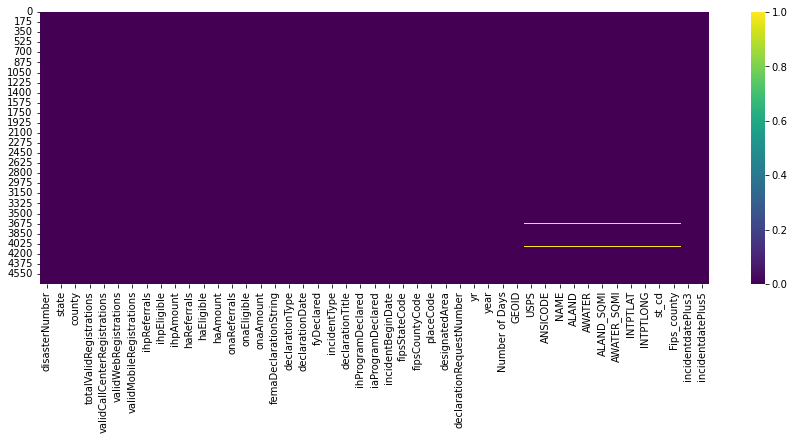

In [26]:
#Visually inspect the nulls
plt.figure(figsize = [15,5])
sns.heatmap(df_fema.isnull(), cmap = 'viridis');

In [27]:
#Convert year to a string and rename the year column for a later join
df_fema.yr = df_fema.yr.astype(str)
df_fema.rename(columns = {'year_S':'year'}, inplace = True)

# Subdivide conus and oconus
df_oConus = df_fema[df_fema['Fips_county'].isnull()].reset_index(drop = True)
df_fema   = df_fema[~df_fema['Fips_county'].isnull()].reset_index(drop = True)


'''
df_oConus is a mix of island territories (excluding Puerto Rico) and First Nations. 
They Include:
   'St. John (Island) (County-equivalent)',
   'St. Thomas (Island) (County-equivalent)',
   'St. Croix (Island) (County-equivalent)',
   'Big Cypress Indian Reservation', 'Brighton Indian Reservation',
   'Fort Pierce Indian Reservation', 'Hollywood Indian Reservation',
   'Immokalee Indian Reservation', 'Tampa Reservation',
   'Eastern (District)', "Manu'a (District)",
   'Rose Island (Island) (County-equivalent)',
   'Swains Island (Island) (County-equivalent)', 'Western (District)',
   'Rota (Municipality)', 'Saipan (Municipality)',
   'Tinian (Municipality)', 'Santee Indian Reservation',
   'Oglala Lakota (County)', 'Guam (County-equivalent)',
   'Northern Mariana Islands (County-equivalent)', 'Bedford',
   'Mississippi Choctaw Indian Reservation',
   'Valdez-Cordova (Census Area)', 'Wade Hampton (Census Area)',
   'Mashantucket Pequot Indian Reservation', 'Mohegan Trust Lands',
   'Lummi Indian Reservation', 'Nooksack Indian Reservation',
   'Quileute Indian Reservation',
   'Salt River Pima-Maricopa Indian Community',
   'Kashunamiut Regional Educational Attendance Area',
   'Seminole Indian Trust Lands'
'''

df_fema.head()

disasterNumber state             county  totalValidRegistrations  \
0            4248    MS    Benton (County)                      159   
1            4248    MS   Coahoma (County)                      271   
2            4248    MS  Marshall (County)                      378   
3            4248    MS    Monroe (County)                       89   
4            4248    MS    Panola (County)                       46   

   validCallCenterRegistrations  validWebRegistrations  \
0                           124                     30   
1                           178                     73   
2                           264                     77   
3                            70                     18   
4                            35                      6   

   validMobileRegistrations  ihpReferrals  ihpEligible   ihpAmount  ...  \
0                         5           134           44   443296.26  ...   
1                        20           241           57   296059.98  ...   
2                        37           326          101  1067090.66  ...   
3                         1            83           46   307400.29  ...   
4                         5            39           10    30547.65  ...   

          ALAND      AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  INTPTLONG  \
0  1.053131e+09   5279183.0     406.616        2.038  34.810518 -89.200285   
1  1.431035e+09  79322563.0     552.526       30.627  34.228670 -90.603165   
2  1.828990e+09   9195190.0     706.177        3.550  34.766190 -89.504231   
3  1.981581e+09  18138022.0     765.093        7.003  33.890030 -88.485038   
4  1.774512e+09  51769784.0     685.143       19.988  34.365205 -89.963065   

  st_cd Fips_county incidentdatePlus3  incidentdatePlus5  
0    28         009        2015-12-26         2015-12-28  
1    28         027        2015-12-26         2015-12-28  
2    28         093        2015-12-26         2015-12-28  
3    28         095        2015-12-26         2015-12-28  
4    28         107        2015-12-26         2015-12-28  

[5 rows x 47 columns]

# Dropping Columns:
>These columns were not specifically related to the questions requested and therefore dropped. 

In [28]:
#Drop the columns
df_fema.drop([#'disasterNumber',
              'validCallCenterRegistrations','validWebRegistrations'
              ,'validMobileRegistrations', 'ihpReferrals'
              #,'ihpEligible'
              #,'ihpAmount'
              ,'haReferrals', 'haEligible', 'haAmount','onaReferrals','onaEligible'
              ,'onaAmount', 'femaDeclarationString','declarationType','declarationDate'
              ,'fyDeclared','declarationTitle', 'ihProgramDeclared','fipsCountyCode'
              ,'iaProgramDeclared'
            # ,'incidentBeginDate'
              , 'fipsStateCode'
              ,'placeCode','designatedArea', 'declarationRequestNumber'
              ,'ANSICODE','NAME','USPS'
             ],axis = 1, inplace = True)

In [29]:
# Rename the state codes and the fips codes
dfcensus.rename(columns  = {'state':'st_cd'
                          ,'county':'Fips_county'}
                ,inplace = True
               )

#Cenusus additional attributes
dfcensus.st_cd = dfcensus.st_cd.astype(str).str.split('.', expand = True)[0]
dfcensus.Fips_county = dfcensus.Fips_county.astype(str).str.split('.', expand = True)[0]
dfcensus['year'] = dfcensus['year'].astype(int).astype(str)

## Merge the Data and Review the Output for Nulls
### Dropping Null Values:
> The heatmap below shows that null values were dropped. The reason for dropping the null values is that it appears that Census does not have corresponding data for the years listed below. Therefore, it is not possible to use the years for which there is FEMA data and not Census Data

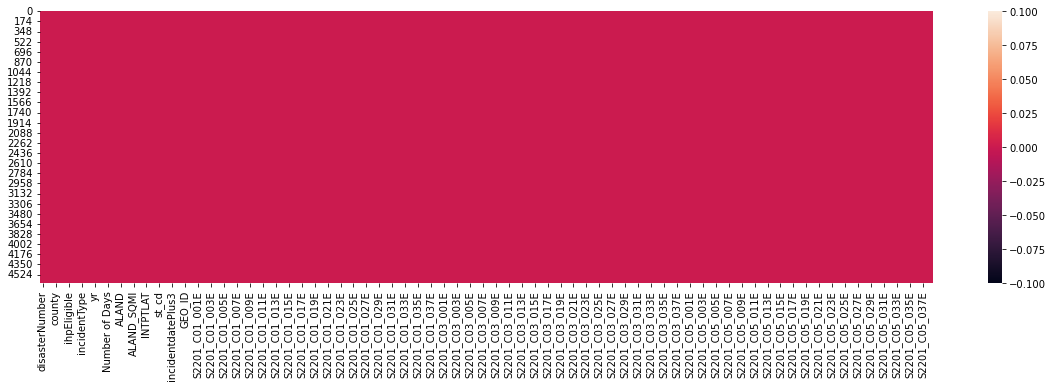

In [30]:
#Merge the fema data and the census data
df= pd.merge(df_fema, dfcensus
             , on  = ['year','Fips_county','st_cd','GEOID']
             , how = 'left'
            ).reset_index(drop = True)

#Investigate the output to determine if there are null values
plt.figure(figsize = [20,5])
sns.heatmap(df.isnull());

In [31]:
# df.drop('rainTotals',axis = 1)
# df[~df['rainTotals'].isnull()].head()[['totalValidRegistrations','rainTotals']]

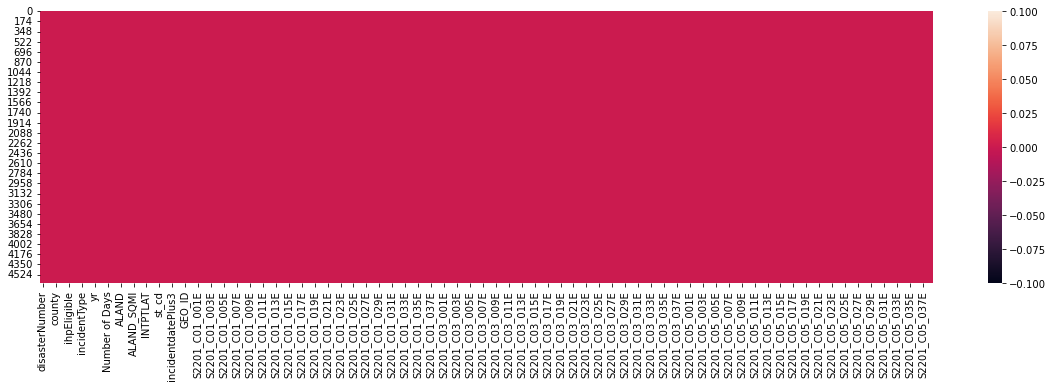

In [32]:
#The null values identified in the above are dropped
df.dropna(axis = 0, inplace = True)
#Output re-investigated
plt.figure(figsize = [20,5])
sns.heatmap(df.isnull());

In [33]:
#The data appears to be highly skewed
df.skew()

disasterNumber             -0.914584
totalValidRegistrations    22.097147
ihpEligible                17.878256
ihpAmount                  24.962966
yr                         -1.498052
                             ...    
S2201_C05_034E            -68.344451
S2201_C05_035E             12.573879
S2201_C05_036E             10.516527
S2201_C05_037E             12.885232
S2201_C05_038E             12.644300
Length: 130, dtype: float64

## Look at the Output after a Log Transformation: Full Dataset

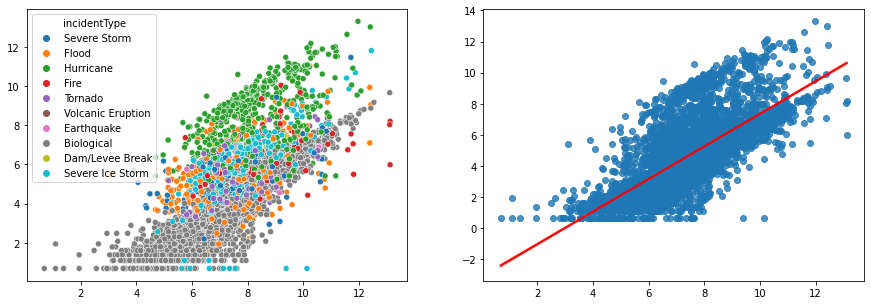

In [34]:
plt.figure(figsize = [15,5])
plt.title('Log Transformed Data')
plt.xlabel('Log Transformed S2201_C01_007E')
plt.ylabel('Log Transformed Valid Registrations')
plt.subplot(1,2,1)
sns.scatterplot(np.log([x+1 for x in df['S2201_C01_007E']])
               ,np.log([x+1 for x in df['totalValidRegistrations']])
               ,hue = df['incidentType']#.astype('category').cat.codes
               )
plt.subplot(1,2,2)
sns.regplot(np.log([x+1 for x in df['S2201_C01_007E']])
           ,np.log([x+1 for x in df['totalValidRegistrations']])
           ,line_kws = {'color':'red'}
            );

## Filter the Dataset for Hurricanes: Create Subdivisions within Hurricane Incident Type
>This section is used to support the idea that creating subdivisions of the data may lead to reduced variance. In all but the bottom quintile, the communityImpact Variable improves the model's performance

In [35]:
#Filter the dataset for only Hurricanes
# df = df[df['totalValidRegistrations']>=10].reset_index(drop = True)
# df_hurricane = df.copy()


dfIncidentType = df[~df['incidentType'].isin(['Biological'
                                             ,'Severe Ice Storm'
                                             ,'Fire','Volcanic Eruption'
                                             ])
                 ]

dfIncidentType = dfIncidentType.reset_index(drop = True)

In [36]:
df_hurricane = dfIncidentType.copy()

# Sub-Divide the Registration Data By Creating a Feature:
> The communityImpact feature subdivides the data and has a very high Pearson Correlation value

In [37]:

## dfDisaster = df_hurricane[~df_['incidentType'].isin(['Biological','Severe Ice Storm','Fire','Volcano'])].reset_index(drop = True)

dfDisaster = dfIncidentType.groupby('disasterNumber')['totalValidRegistrations'].sum()
dfDisaster = dfDisaster.reset_index()
dfDisaster['disasterSize']= pd.qcut(dfDisaster.loc[:,'totalValidRegistrations']
                                   ,5
                                   ,labels =["Very Small","Small"
                                            ,"Medium" ,"Large"
                                            ,"Very Large"
                                            ]
                                   )
dfDisaster['disasterSize']= dfDisaster['disasterSize'].map({"Very Small":0
                                                            ,"Small":0
                                                            , "Medium":0
                                                            , "Large":0
                                                            , "Very Large":1
                                                            }
                                                           )

dfDisaster = dfDisaster[['disasterNumber','disasterSize']]

dfIncidentType = pd.merge(dfIncidentType,dfDisaster, on ='disasterNumber', how = 'left')
# df_hurricane.head()

In [38]:


# Subdivide the disasters into 5 groups using the ratio of the number of registrations by househould
dfIncidentType['communityImpact']= pd.qcut(dfIncidentType.loc[:,'totalValidRegistrations']\
                                        /dfIncidentType.loc[:,'S2201_C01_001E']#Number of Households
                                        ,5
                                        ,labels =["Very Low",
                                                 "Low"
                                                 , "Medium"
                                                 , "Large"                                    
                                                 , "Catastrophic"
                                             ]
                                        )

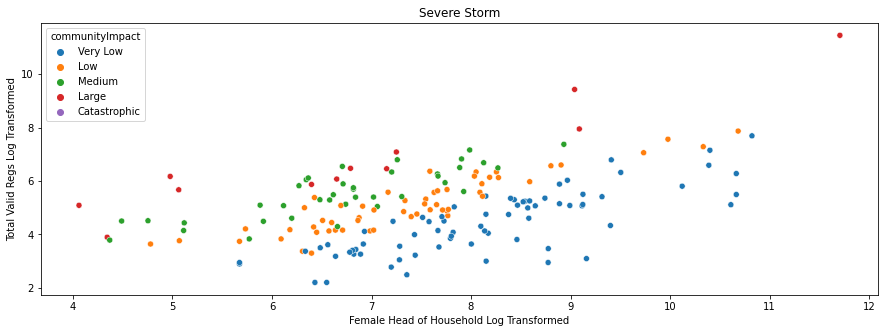

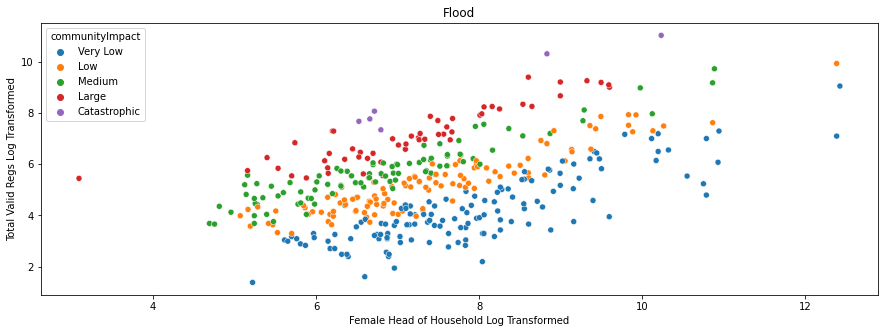

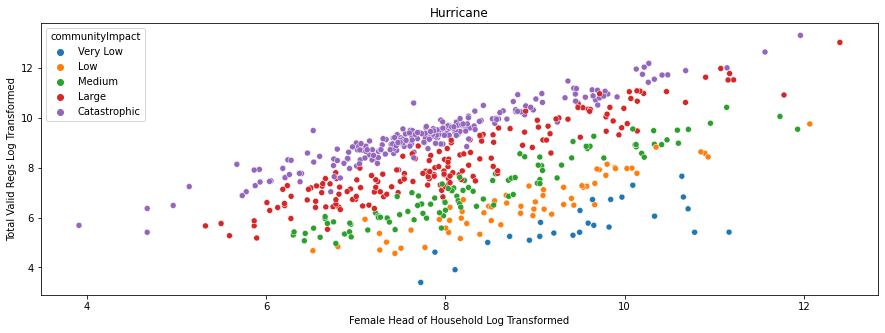

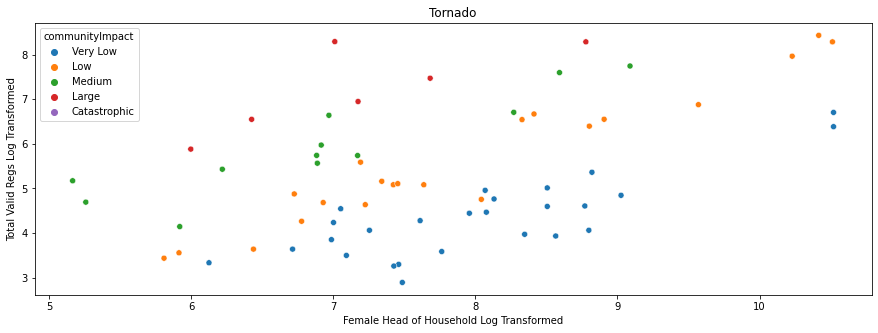

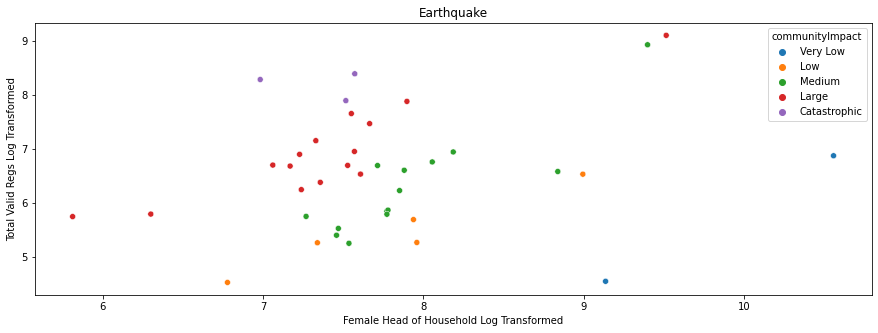

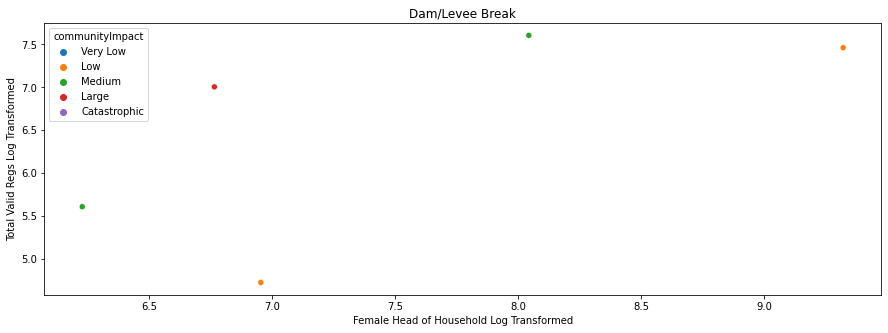

In [39]:
for incidentType in df_hurricane['incidentType'].unique():
    plt.figure(figsize=[15,5])
    plt.title(incidentType)
    plt.xlabel('Female Head of Household Log Transformed')
    plt.ylabel('Total Valid Regs Log Transformed')
    df_type = dfIncidentType[dfIncidentType['incidentType']==incidentType]
    sns.scatterplot(np.log([x+1 for x in df_type['S2201_C01_007E']])
               ,np.log([x+1 for x in df_type['totalValidRegistrations']])
               ,hue = df_type['communityImpact'] 
               )
    plt.show()

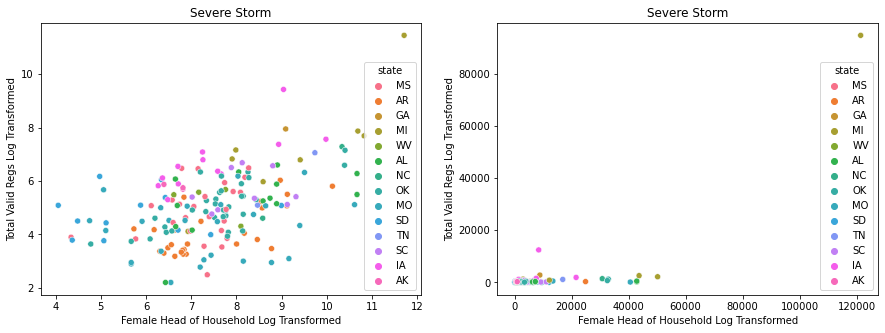

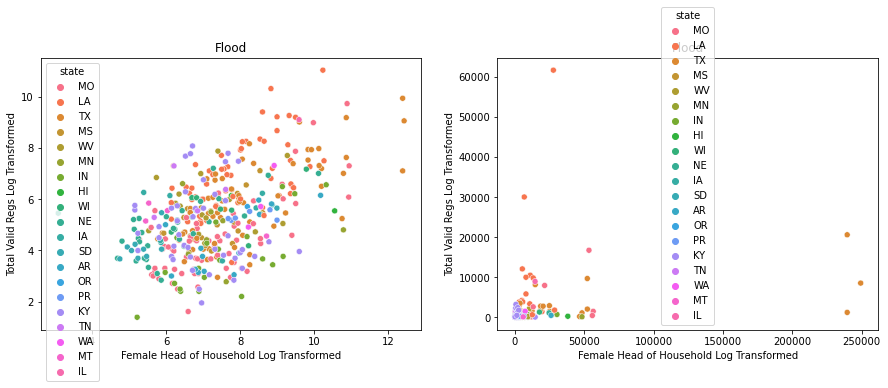

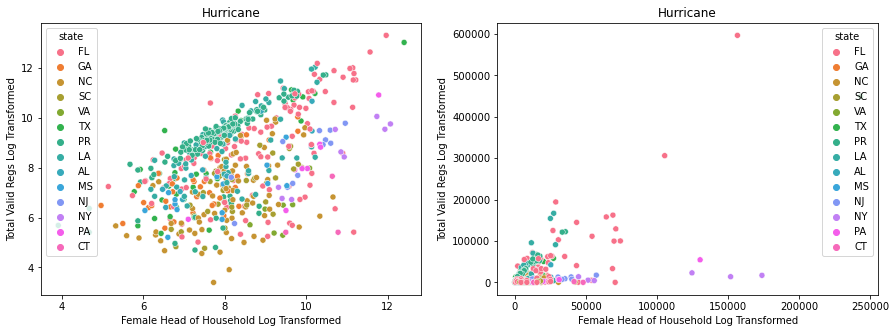

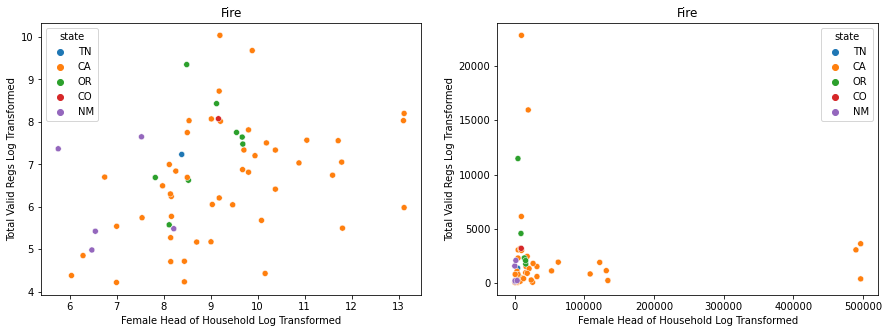

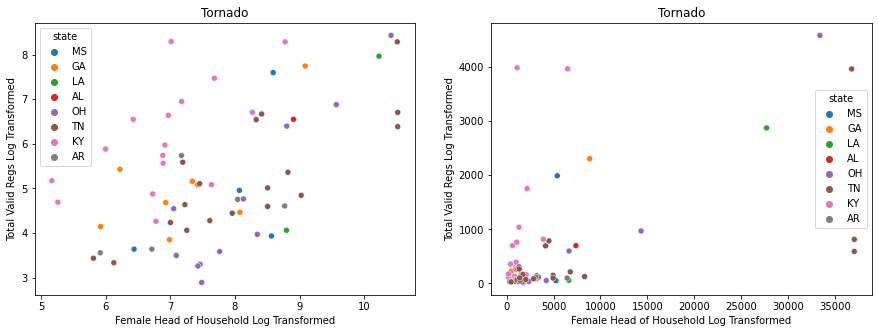

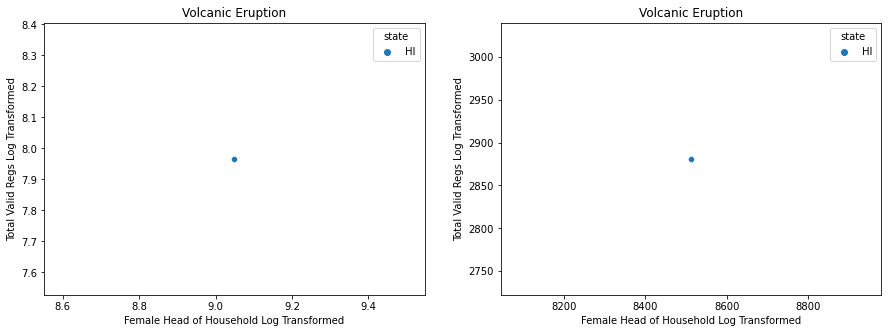

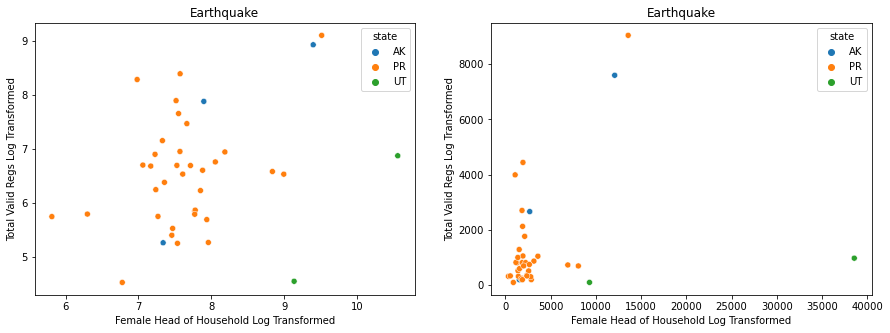

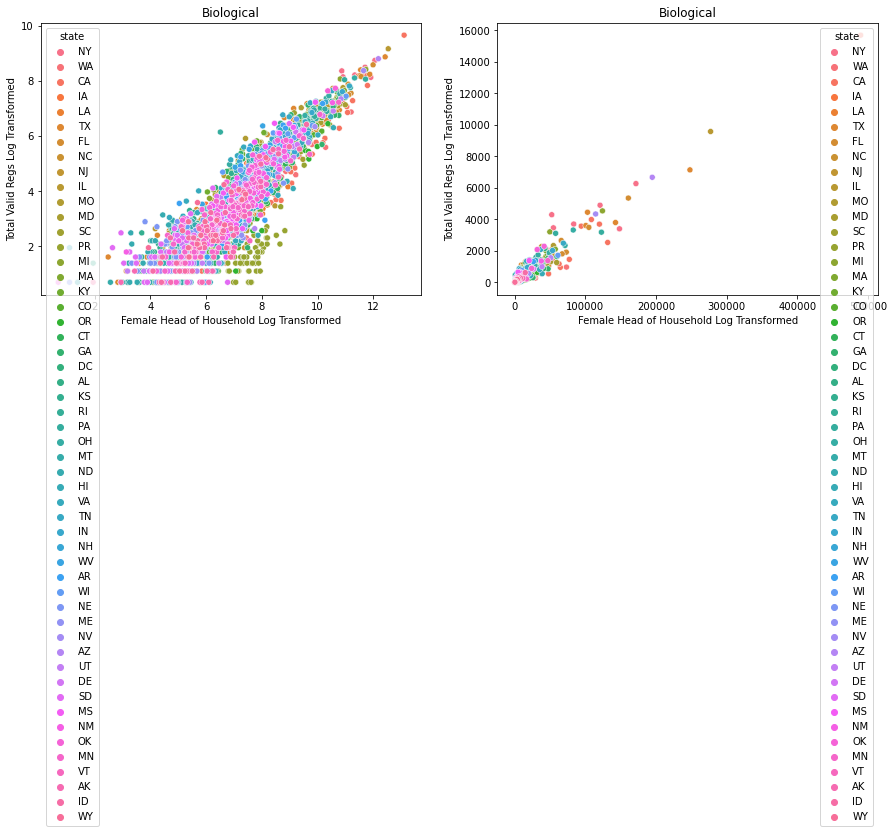

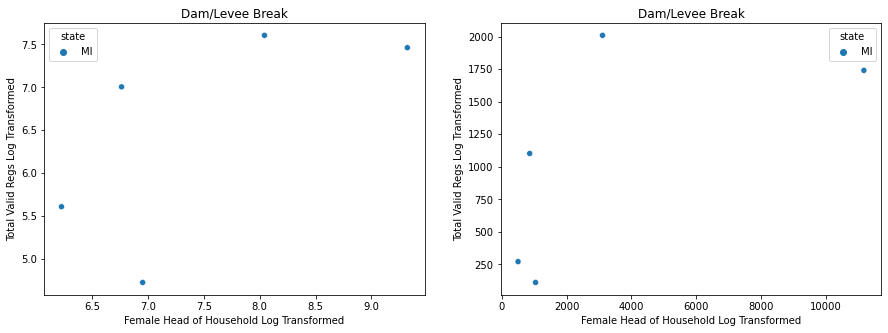

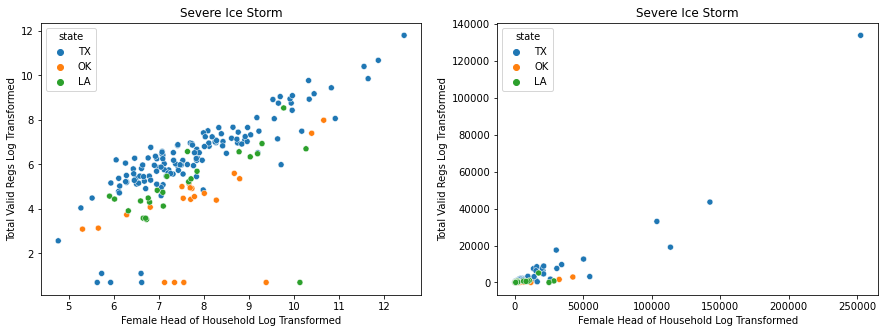

In [40]:
for incidentType in df['incidentType'].unique():
    plt.figure(figsize=[15,5])
    plt.title(incidentType)
#     plt.xlabel('Female Head of Household Log Transformed')
#     plt.ylabel('Total Valid Regs Log Transformed')
    df_type = df[df['incidentType']==incidentType]
    plt.subplot(1,2,1)
    plt.xlabel('Female Head of Household Log Transformed')
    plt.ylabel('Total Valid Regs Log Transformed')
    plt.title(incidentType)
    sns.scatterplot(np.log([x+1 for x in df_type['S2201_C01_007E']])
               ,np.log([x+1 for x in df_type['totalValidRegistrations']])
               ,hue = df_type['state'] 
               )
    plt.subplot(1,2,2)
    plt.title(incidentType)
    plt.xlabel('Female Head of Household Log Transformed')
    plt.ylabel('Total Valid Regs Log Transformed')
    sns.scatterplot(df_type['S2201_C01_007E']
               , df_type['totalValidRegistrations']
               ,hue = df_type['state']
               )
    plt.show()

# 3. Data Preparation: 
* Inspect the Relationship between Female Householders and Registrations:
> While the overall relationship is fairly weak, the subdivided relationship appears to be quite strong in almost all subdivisions; only the very small applications to registration ratio appears to have a moderate relationship. Additionally, an unsupervised model was evaluated below to determine if it could generate similar linear clusters. Because it cannot, a classification model may be necessary to predict the groupings. 

0.49420328762589016


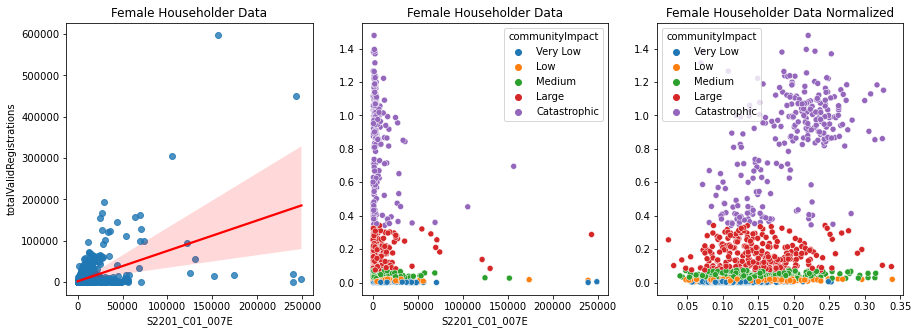

In [41]:
#The data below does not show linearity. It is probably necessary to log-transform the data. 
plt.figure(figsize = [15,5])

plt.subplot(1,3,2)
plt.title('Female Householder Data')
plt.xlabel('S2201_C01_007E')
#Log transformation of Female Householder  
scatter_1 = sns.scatterplot(dfIncidentType['S2201_C01_007E'] #Female householder,
                           , dfIncidentType['totalValidRegistrations']/dfIncidentType['S2201_C01_001E']
                           ,hue = dfIncidentType['communityImpact']#.astype('category').cat.codes
                           )

plt.subplot(1,3,1)
plt.title('Female Householder Data')
plt.xlabel('S2201_C01_007E')
S_corr = dfIncidentType[['totalValidRegistrations','S2201_C01_007E']].corr(method = 'spearman').values[0][1]
print(S_corr)
scatter_2 = sns.regplot(dfIncidentType['S2201_C01_007E']
                        ,dfIncidentType['totalValidRegistrations']
                        ,line_kws = {'color':'red'}
                        )
#
plt.subplot(1,3,3)
plt.title('Female Householder Data Normalized')
plt.xlabel('S2201_C01_007E')
scatter_2 = sns.scatterplot( dfIncidentType['S2201_C01_007E']/dfIncidentType['S2201_C01_001E']
                        , dfIncidentType['totalValidRegistrations']/dfIncidentType['S2201_C01_001E']
                        ,hue = dfIncidentType['communityImpact']#rainImpact
                        )


In [42]:
km = KMeans(n_clusters = 5)
y_pred_km = km.fit_predict(dfIncidentType[['S2201_C01_007E','totalValidRegistrations']])
dfIncidentType['cluster'] = y_pred_km

0.49420328762589016


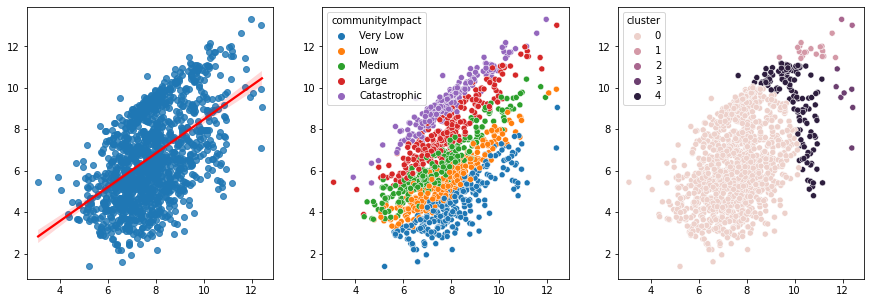

In [43]:
plt.figure(figsize = [15,5])
plt.title('Log Transformed Data')
plt.xlabel('S2201_C01_007E')
plt.subplot(1,3,2)
#Log transformation of Female Householder  
scatter_1 = sns.scatterplot(np.log([x+1 for x in dfIncidentType['S2201_C01_007E']]) #Female householder,
                           ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                           ,hue = dfIncidentType['communityImpact']#.astype('category').cat.codes
                           )

plt.subplot(1,3,1)
S_corr = dfIncidentType[['totalValidRegistrations','S2201_C01_007E']].corr(method = 'spearman').values[0][1]
print(S_corr)
scatter_2 = sns.regplot(np.log([x+1 for x in dfIncidentType['S2201_C01_007E']])
                        ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                        ,line_kws = {'color':'red'}
                        )
#
plt.subplot(1,3,3)
# print(S_corr)
scatter_2 = sns.scatterplot(np.log([x+1 for x in dfIncidentType['S2201_C01_007E']])
                        ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                        ,hue = dfIncidentType['cluster']#rainImpact
                        )


### S2201_C01_002E: Census Variable for People over 60
>Estimate!!Total!!Households!!With one or more people in the household 60 years and over

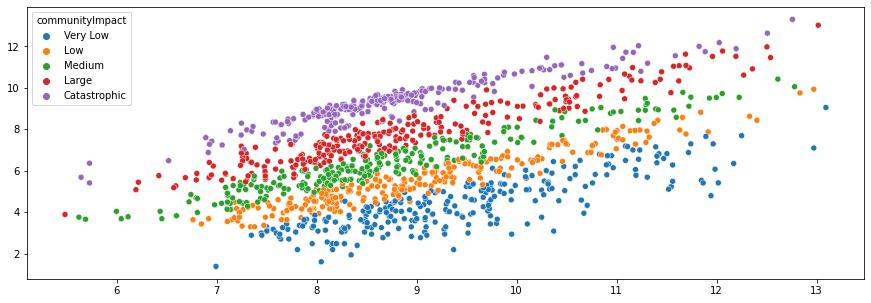

In [44]:
#This is an expanded version of the chart on the right. It appears very linear
plt.figure(figsize = [15,5])
sns.scatterplot(np.log([x+1 for x in dfIncidentType['S2201_C01_002E']])
                ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                ,hue = dfIncidentType['communityImpact']#
                );

## Regplot: Question 2
>How might we subdivide the data to reduce the variance?: **Create a ratio of Valid Registrations to Households**


### S2201_C01_002E: Elderly

Medium Community Impact: Spearman Correlation 0.94
Very Low Community Impact: Spearman Correlation 0.82
Low Community Impact: Spearman Correlation 0.95
Large Community Impact: Spearman Correlation 0.94
Catastrophic Community Impact: Spearman Correlation 0.93


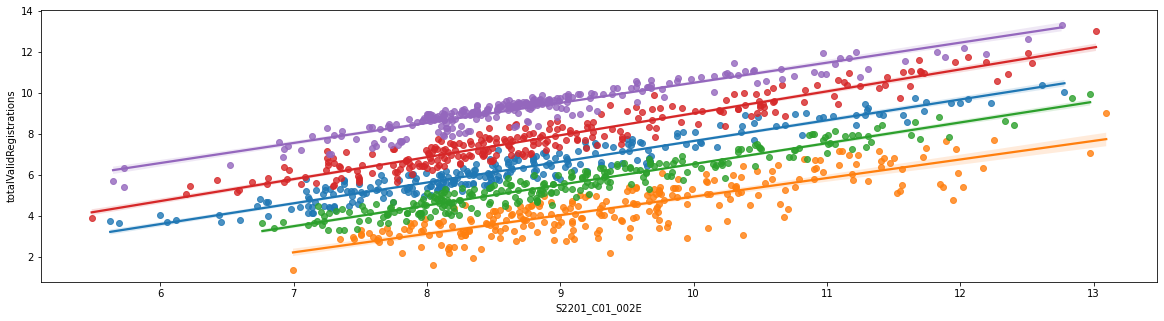

In [45]:
plt.figure(figsize = [20,5])
#Elderly
community_impact('S2201_C01_002E','totalValidRegistrations')

Medium Community Impact: Spearman Correlation 0.84
Very Low Community Impact: Spearman Correlation 0.71
Low Community Impact: Spearman Correlation 0.87
Large Community Impact: Spearman Correlation 0.89
Catastrophic Community Impact: Spearman Correlation 0.85


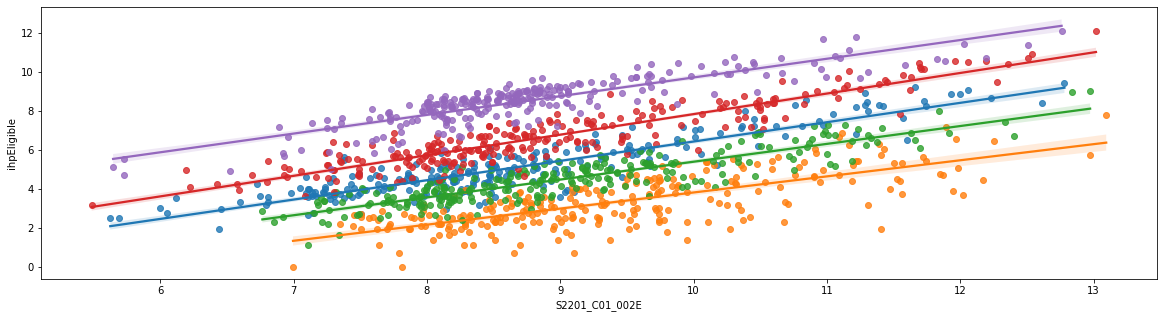

In [46]:
plt.figure(figsize = [20,5])
#Elderly
community_impact('S2201_C01_002E','ihpEligible')


In [47]:
# plt.figure(figsize = [20,5])
# #Elderly
# community_impact('S2201_C01_002E','ihpAmount')
# #,'ihpEligible'
# #,'ihpAmount'

### S2201_C01_007E: Female Head of Household

Medium Community Impact: Spearman Correlation 0.93
Very Low Community Impact: Spearman Correlation 0.83
Low Community Impact: Spearman Correlation 0.93
Large Community Impact: Spearman Correlation 0.92
Catastrophic Community Impact: Spearman Correlation 0.94


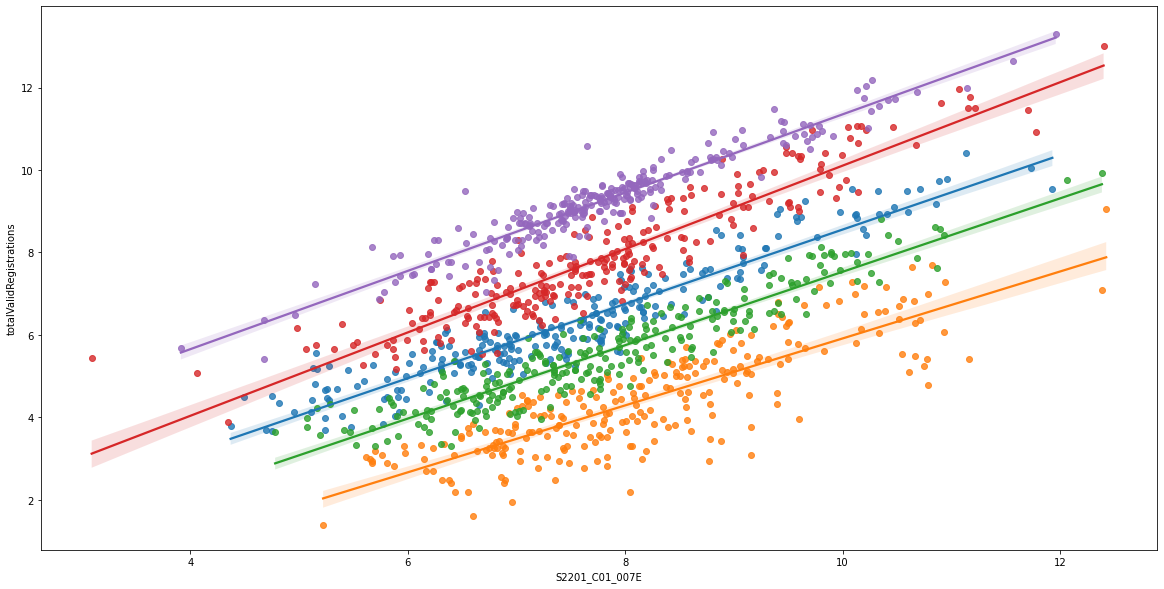

In [48]:
plt.figure(figsize = [20,10])
#Female Head of Household
community_impact('S2201_C01_007E','totalValidRegistrations')

Medium Community Impact: Spearman Correlation 0.82
Very Low Community Impact: Spearman Correlation 0.72
Low Community Impact: Spearman Correlation 0.83
Large Community Impact: Spearman Correlation 0.85
Catastrophic Community Impact: Spearman Correlation 0.87


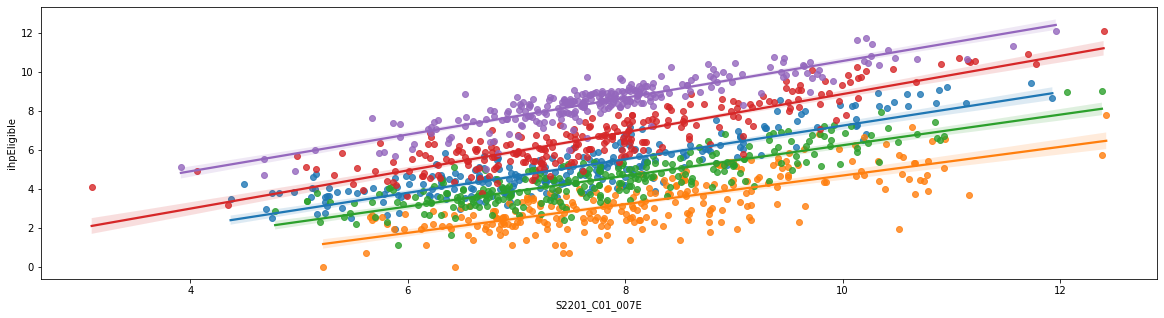

In [49]:
plt.figure(figsize = [20,5])
community_impact('S2201_C01_007E','ihpEligible')


In [50]:
# plt.figure(figsize = [20,5])
# #Elderly
# community_impact('S2201_C01_002E','ihpAmount')

### S2201_C01_023E: Disability

Medium Community Impact: Spearman Correlation 0.92
Very Low Community Impact: Spearman Correlation 0.83
Low Community Impact: Spearman Correlation 0.93
Large Community Impact: Spearman Correlation 0.93
Catastrophic Community Impact: Spearman Correlation 0.89


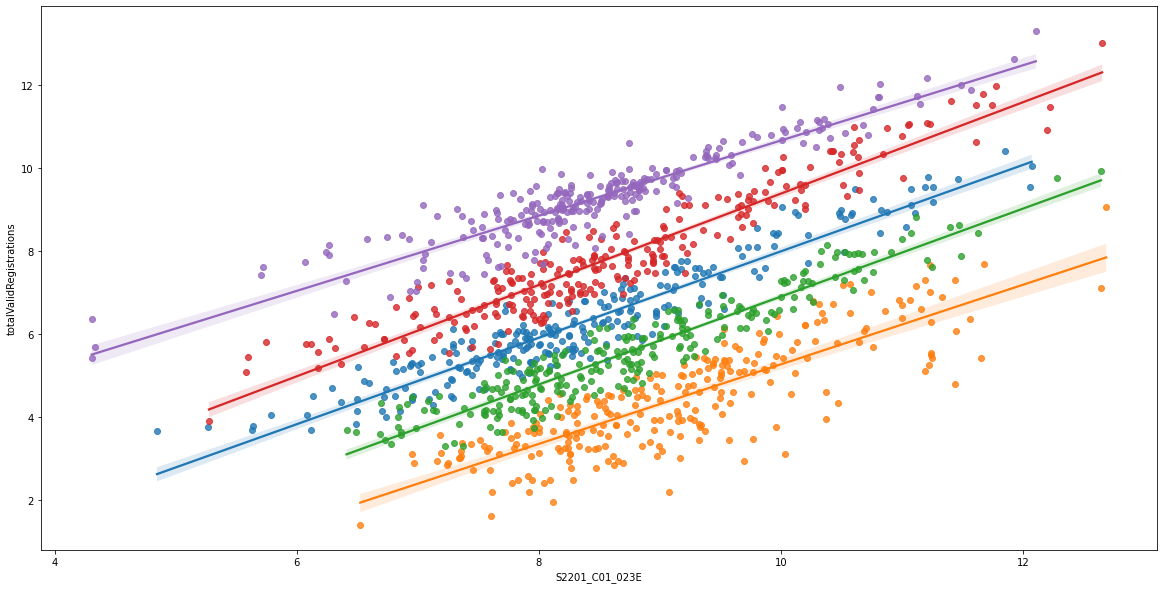

In [51]:
plt.figure(figsize = [20,10])
community_impact('S2201_C01_023E','totalValidRegistrations')

Medium Community Impact: Spearman Correlation 0.83
Very Low Community Impact: Spearman Correlation 0.72
Low Community Impact: Spearman Correlation 0.84
Large Community Impact: Spearman Correlation 0.88
Catastrophic Community Impact: Spearman Correlation 0.81


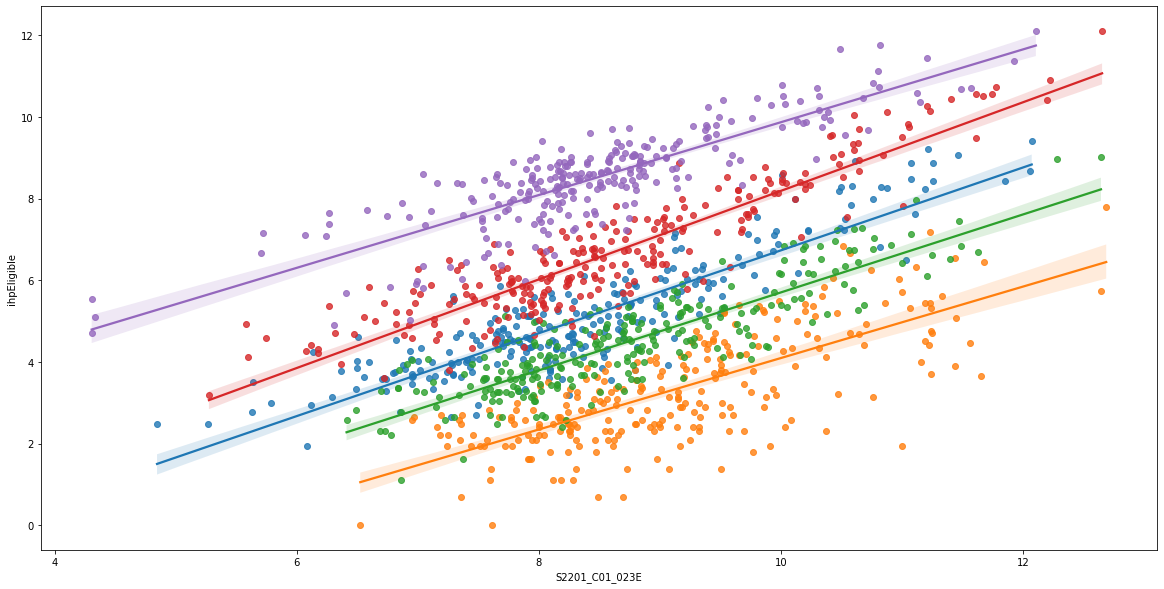

In [52]:
plt.figure(figsize = [20,10])
community_impact('S2201_C01_023E','ihpEligible')

In [53]:
# plt.figure(figsize = [20,10])
# community_impact('S2201_C01_023E','ihpAmount')

### S2201_C03_001E: Supplemental Nutrition Assistance Program

Medium Community Impact: Spearman Correlation 0.88
Very Low Community Impact: Spearman Correlation 0.81
Low Community Impact: Spearman Correlation 0.90
Large Community Impact: Spearman Correlation 0.88
Catastrophic Community Impact: Spearman Correlation 0.90


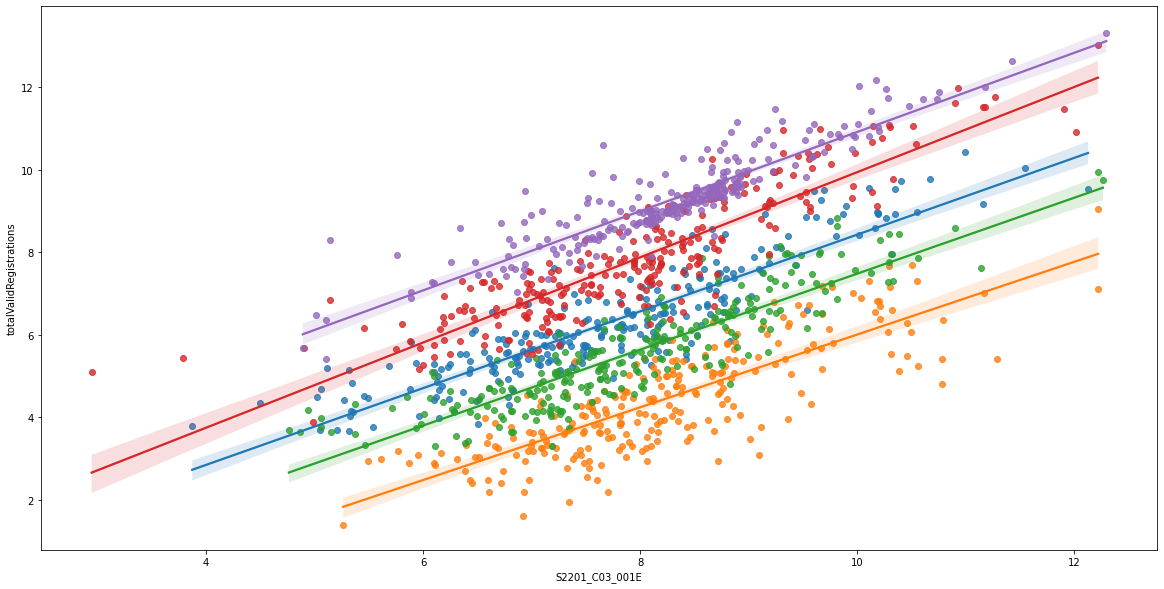

In [54]:
plt.figure(figsize = [20,10])
community_impact('S2201_C03_001E','totalValidRegistrations')

Medium Community Impact: Spearman Correlation 0.80
Very Low Community Impact: Spearman Correlation 0.70
Low Community Impact: Spearman Correlation 0.80
Large Community Impact: Spearman Correlation 0.82
Catastrophic Community Impact: Spearman Correlation 0.86


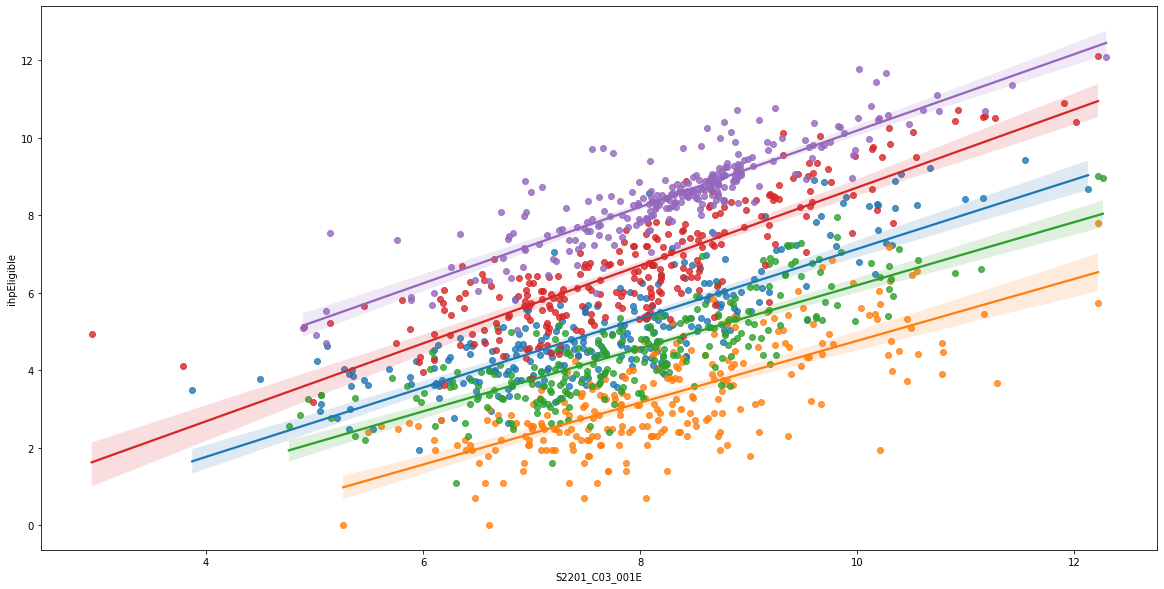

In [55]:
plt.figure(figsize = [20,10])
community_impact('S2201_C03_001E','ihpEligible')

In [56]:
# plt.figure(figsize = [20,10])
# community_impact('S2201_C03_001E','ihpAmount')

## For Each of the Above, the Very Small Disaster had an R^2 of under 70%. 
> Investigated all of the elements in the Table to see if a better result could be identified

In [57]:
df_hurricane = dfIncidentType.copy()
dfIncidentType.head()

disasterNumber state             county  totalValidRegistrations  \
0            4248    MS    Benton (County)                      159   
1            4248    MS   Coahoma (County)                      271   
2            4248    MS  Marshall (County)                      378   
3            4248    MS    Monroe (County)                       89   
4            4248    MS    Panola (County)                       46   

   ihpEligible   ihpAmount  incidentType incidentBeginDate    yr  year  ...  \
0           44   443296.26  Severe Storm        2015-12-23  2016  2016  ...   
1           57   296059.98  Severe Storm        2015-12-23  2016  2016  ...   
2          101  1067090.66  Severe Storm        2015-12-23  2016  2016  ...   
3           46   307400.29  Severe Storm        2015-12-23  2016  2016  ...   
4           10    30547.65  Severe Storm        2015-12-23  2016  2016  ...   

   S2201_C05_032E S2201_C05_033E  S2201_C05_034E  S2201_C05_035E  \
0            48.0         1727.0         41385.0          1856.0   
1             8.0         2211.0         38920.0          3339.0   
2           383.0         6091.0         44271.0          7844.0   
3            61.0         8577.0         45406.0          7801.0   
4            81.0         6021.0         44873.0          6592.0   

   S2201_C05_036E  S2201_C05_037E  S2201_C05_038E  disasterSize  \
0           395.0           757.0           704.0             0   
1           558.0          1337.0          1444.0             0   
2          1329.0          2996.0          3519.0             0   
3          1505.0          2656.0          3640.0             0   
4          1395.0          2363.0          2834.0             0   

  communityImpact cluster  
0          Medium       0  
1          Medium       0  
2          Medium       0  
3        Very Low       0  
4        Very Low       0  

[5 rows x 141 columns]

## Feature Selection Begin for Features of Interest

In [58]:
#Filter for the values of interest
df_hurricane = df_hurricane[['totalValidRegistrations'
                             #,'incidentType'
                             ,'disasterSize'
                             ,'Number of Days'
                             ,'AWATER_SQMI'
                             ,'communityImpact'
                             #Poverty
                             ,'S2201_C01_021E'
                             #Snap
                             ,'S2201_C03_001E'
                             #No workers in past 12 months
                             ,'S2201_C01_036E'
                             #With one or more people with a disability
                             ,'S2201_C01_023E'
                             #Female householder, no spouse present
                             ,'S2201_C01_007E'
                             #With one or more people in the household 60 years and over
                             ,'S2201_C01_002E'
                            ]]


#NOAA Values Removed
# df_hurricane = pd.merge(df_hurricane,noaa_df, on = ['incidentBeginDate','GEOID'], how = 'inner')
# df_hurricane.drop(['incidentBeginDate','GEOID'], axis = 1, inplace = True)
#Log-transform the data to ensure linearity




for col in df_hurricane.columns:
    #if col in ['communityImpact','disasterSize','incidentType']: #'Number of Days' is only sometimes skewed
    if col in ['communityImpact'
               #,'disasterSize'
               ,'PRCP']:
        continue
    try:
        df_hurricane[f'{col}'] = np.log([x+1 for x in df_hurricane[f'{col}']])
    except:
        pass

#Convert the Incident Type and Community Impact to Dummies
df_hurricane = pd.get_dummies(df_hurricane, columns = ['communityImpact',
                                                       #'incidentType'
                                                      ], drop_first = True)


# Review the Data Skew
# df_hurricane.skew()

In [59]:
df_hurricane.columns

Index(['totalValidRegistrations', 'disasterSize', 'Number of Days',
       'AWATER_SQMI', 'S2201_C01_021E', 'S2201_C03_001E', 'S2201_C01_036E',
       'S2201_C01_023E', 'S2201_C01_007E', 'S2201_C01_002E',
       'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

## Appears to be some multi-collinearity. 
1. For S2201_C01_007E/S2201_C01_002E, we will use the Lasso Coeficients mitigate it
2. There is concern about creating a confounding variable. CommunityImpact uses households and valid Registrations
    * There does not appear to be a correlation between the dummy variables and the target or indpendent Vars
    * Therefore Moved forward with this forecast

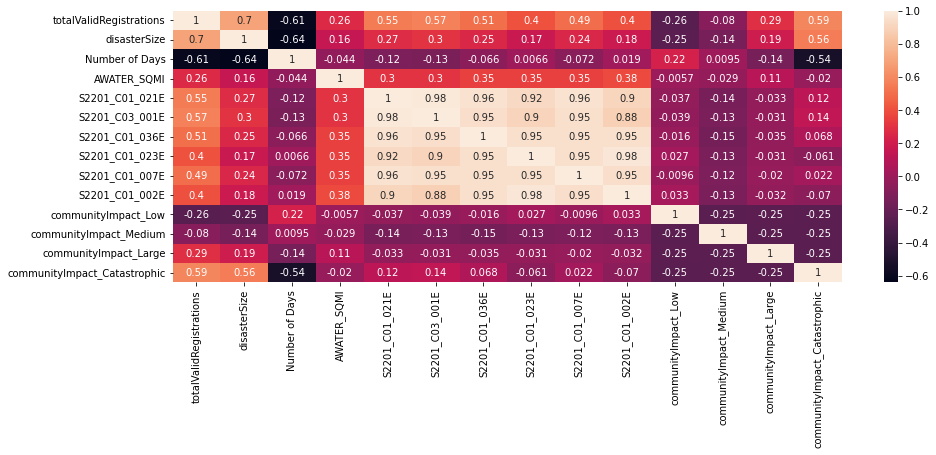

In [60]:
#Use the Heatmap to investigate for multi-collinearity
plt.figure(figsize = [15,5])
df_hurricane.skew()
sns.heatmap(df_hurricane.corr(method = 'spearman'), annot = True);


## 4. Begin Modeling

In [61]:
#Split the data to look at the P-Values
y = df_hurricane['totalValidRegistrations'].values.reshape(-1, 1)
X = df_hurricane.drop(['totalValidRegistrations'], axis = 1).reset_index(drop = True)


In [62]:
names = X.columns

## Investigate Null Values
> No values were dropped, but before modeling this is a good check. 

In [63]:
# plt.figure(figsize= [15,5])

#The model will break if there are nulls, this is the last check for nulls before modeling
# sns.heatmap(X.isnull())

In [64]:
#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                             )
#For the visualization below, the column names are required as a list
# names = X_train.columns

In [65]:
#Random Forest Regression
rfr = RFR(n_estimators = 1000, criterion = 'squared_error', random_state = 42)
rfr.fit(X_train,y_train.flatten())


RandomForestRegressor(n_estimators=1000, random_state=42)

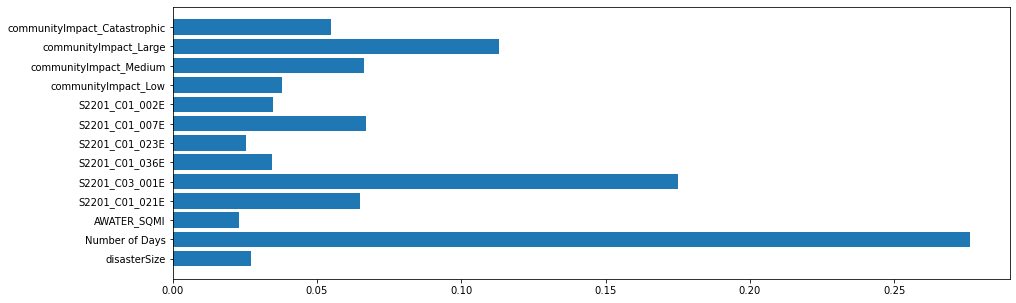

Feature Importance Values:
 [0.02719842 0.27612693 0.02285894 0.06483516 0.17512991 0.03429667
 0.02554079 0.06700488 0.03479555 0.03774507 0.06634524 0.11309037
 0.05503207]


In [66]:
#Visually inspect the feature importances: None are listed at zero
plt.figure(figsize = [15,5])
plt.barh(names,rfr.feature_importances_)
plt.show();
print('Feature Importance Values:\n',rfr.feature_importances_)

In [67]:
#This is the first prediction with the available information using Random Forest
rfr_pred = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_pred)
rfr_score

0.831120490387983

# 5. Evaluation: Begin Processing the Data:
1. Remove Values with High P-Values
2. Use the Lasso Coeficients to determine features of importance
> The idea for the below dictionary came from the following location: https://www.statology.org/statsmodels-linear-regression-p-value

## Question 3: Relationship between geographic elements and target variable
>In the below output, we see that Area of Water Square Miles has a p-value above 0.05 therefore, we exclude it and can determine that water square miles is not a good indicator. 

In [68]:
#R^2 and Adjusted R^2 are very high. Some elements have very high p-values. Must be removed/
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train,  X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     324.0
Date:                Thu, 19 Jan 2023   Prob (F-statistic):          9.42e-195
Time:                        06:50:19   Log-Likelihood:                -260.76
No. Observations:                 389   AIC:                             549.5
Df Residuals:                     375   BIC:                             605.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [69]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'disasterSize': 0.6556467859844216,
 'Number of Days': 0.04053735352314884,
 'AWATER_SQMI': 0.9259068348680078,
 'S2201_C01_021E': 0.11406215908633423,
 'S2201_C03_001E': 0.004162840073887053,
 'S2201_C01_036E': 0.05609960891217569,
 'S2201_C01_023E': 0.0769623099295522,
 'S2201_C01_007E': 2.3088377496528574e-05,
 'S2201_C01_002E': 0.9020106111267595,
 'communityImpact_Low': 3.617441522565616e-60,
 'communityImpact_Medium': 2.8710021619358658e-98,
 'communityImpact_Large': 1.8998471465653821e-122,
 'communityImpact_Catastrophic': 1.6922504171365977e-83}

In [70]:
#Create a dataFrame that removes any element with a P-Value greater than 0.05
df_pvalue = pd.DataFrame()
column=[]
p_value=[]
for key ,value in pvalue_dict.items():
    if value >0.05:
        pass
    else:
        col = pd.Series(key)
        val = pd.Series(value)
        column.append(col)
        p_value.append(val)
        
df_pvalue['ColumnName'] = pd.Series(column)
df_pvalue['p_value'] = pd.Series(p_value)
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].astype(str).str.lstrip(' ')
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].str.split('\n', expand = True)[0]
df_pvalue['ColumnName']= df_pvalue['ColumnName'].str.split('0  ', expand = True)[1]
columns =list(df_pvalue['ColumnName'].str.strip(' '))

#Filter the columns for the X Variable using the output from the above transformation
X = X[columns]

#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )
#Again use the Names to create a list of columns for the Lasso Visualization
names = X_train.columns
names

Index(['Number of Days', 'S2201_C03_001E', 'S2201_C01_007E',
       'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

In [71]:
#Split the data into test and train
# X = X.drop('S2201_C01_002E',axis = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )

In [72]:
# Use stats models api to check the P-Value and the adjusted R^2
# See how close the R^2 and adjusted R^2 are. P-values near zero
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train, X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     516.3
Date:                Thu, 19 Jan 2023   Prob (F-statistic):          4.54e-190
Time:                        06:50:19   Log-Likelihood:                -290.73
No. Observations:                 389   AIC:                             597.5
Df Residuals:                     381   BIC:                             629.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [73]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'Number of Days': 0.08820207416832587,
 'S2201_C03_001E': 0.7622647547713188,
 'S2201_C01_007E': 7.023788408958056e-16,
 'communityImpact_Low': 6.581041279180266e-52,
 'communityImpact_Medium': 1.1671581181007295e-89,
 'communityImpact_Large': 2.993038796761046e-117,
 'communityImpact_Catastrophic': 1.397754179337869e-79}

In [74]:
#Create a dataFrame that removes any element with a P-Value greater than 0.05
df_pvalue = pd.DataFrame()
column=[]
p_value=[]
for key ,value in pvalue_dict.items():
    if value >0.05:
        pass
    else:
        col = pd.Series(key)
        val = pd.Series(value)
        column.append(col)
        p_value.append(val)
        
df_pvalue['ColumnName'] = pd.Series(column)
df_pvalue['p_value'] = pd.Series(p_value)
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].astype(str).str.lstrip(' ')
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].str.split('\n', expand = True)[0]
df_pvalue['ColumnName']= df_pvalue['ColumnName'].str.split('0  ', expand = True)[1]
columns =list(df_pvalue['ColumnName'].str.strip(' '))

#Filter the columns for the X Variable using the output from the above transformation
X = X[columns]

#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )
#Again use the Names to create a list of columns for the Lasso Visualization
names = X_train.columns
names

Index(['S2201_C01_007E', 'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

# Use Lasso for Feature Selection

In [75]:
#Lasso regularization for feature selection
lasso = Lasso()
lasso.fit(X_train,y_train)
#Visualize the coefficients. Unused coefficients will go to zero
lasso_coef = lasso.coef_

In [76]:
## Question 1: Which Feature has the highest utility in a model##
            ## Answer: S2201_C01_002E ##
    ## Reasoning: Lasso Regularization Vizualization ##

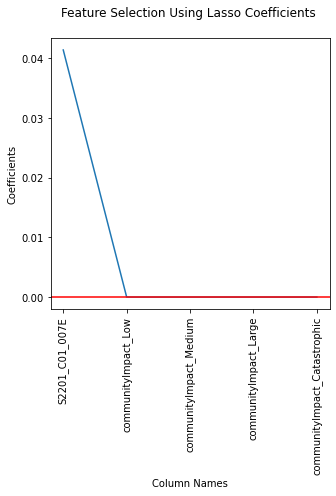

In [77]:
#Used for Feature Selection: 
 #The visualization indicates Households with sixty or greater is the best predictor variable
plt.figure(figsize = [5,5])

lasso1 = plt.plot(range(len(names)),lasso_coef)
plt.xticks(range(len(names)),names, rotation = 90)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.ylabel('Coefficients')
plt.xlabel('Column Names')
plt.title('Feature Selection Using Lasso Coefficients \n')

# plt.savefig('Lasso Feature Selection.jpg')
plt.show();

In [78]:
# # Reduce the number of columns to only those that are identified by Lasso with a coef>0
# #  Because we know that the community impact is important to subdiving the data, 
# #  only S2201 columns are removed. 
if len(lasso_coef)>1:
    data = zip(names,lasso_coef)
    data = pd.DataFrame(data)
    column_drop = data[data[0].str.contains('S2201')& (data[1]==0)][0].values
    X = X.drop(column_drop, axis = 1)
    print('complete Lasso: ','There are {} columns'.format(len(lasso_coef)))
else:
    X=X
    print('incomplete Lasso: ','There are {} columns'.format(len(lasso_coef)))

X.columns


complete Lasso:  There are 5 columns


Index(['S2201_C01_007E', 'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

In [79]:
# X.drop('S2201_C01_007E',axis =1, inplace = True)

# Evaluate the Final Models

In [80]:
#Split the data into test and train
# X = X.drop('S2201_C01_002E',axis = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )

In [81]:
# Use stats models api to check the P-Value and the adjusted R^2
# See how close the R^2 and adjusted R^2 are. P-values near zero
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train, X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     720.5
Date:                Thu, 19 Jan 2023   Prob (F-statistic):          2.71e-192
Time:                        06:50:20   Log-Likelihood:                -292.22
No. Observations:                 389   AIC:                             596.4
Df Residuals:                     383   BIC:                             620.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [82]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'S2201_C01_007E': 1.7923430505146401e-134,
 'communityImpact_Low': 2.214463645935614e-58,
 'communityImpact_Medium': 8.753442090552238e-111,
 'communityImpact_Large': 1.7102869527835773e-149,
 'communityImpact_Catastrophic': 3.1037366637986536e-90}

In [83]:
#Lasso Regularization Forecast
lasso.fit(X_train,y_train)
lasso_pred = lasso.predict(X_test)
lasso_score = r2_score(y_test,lasso_pred)
# print the R^2 Value of Lasso score
lasso_score

-0.3433382363363413

In [84]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

lr_score = r2_score(y_test,y_pred)

# print the R^2 Value of score
lr_score

0.9337937882451145

In [85]:
#Random Forest Regression
rfr = RFR(n_estimators = 1000, criterion = 'squared_error', random_state = 42)
rfr.fit(X_train,y_train.flatten())
rfr_pred = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_pred)
rfr_score

0.8588434241956376

In [86]:

#MSE lr: Not rmse because values are log transformed
lr_mse = mean_squared_error(y_test,y_pred)
lr_rmse = np.sqrt(lr_mse)

#MSE Lasso
lasso_mse = mean_squared_error(y_test,lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)

#MSE rfr
rfr_mse = mean_squared_error(y_test,rfr_pred)
rfr_rmse = np.sqrt(rfr_mse)

print('The Linear Regression Mean Squared error is: {:.3f}'.format(lr_rmse))
# print('The Lasso Regression Mean Squared error is: {:.3f}'.format(lasso_rmse))
print('The Random Forest Mean Squared error is: {:.3f}'.format(rfr_rmse))

The Linear Regression Mean Squared error is: 0.577
The Random Forest Mean Squared error is: 0.842


In [87]:
#Compare the R^2 results
print('The Linear Regression r^2 value for this model is: {:.3f}'.format(lr_score))
# print('The Lasso Regression r^2 value for this model is: {:.2f}'.format(lasso_score))
print('The Random Forest r^2 value for this model is: {:.3f}'.format(rfr_score))

The Linear Regression r^2 value for this model is: 0.934
The Random Forest r^2 value for this model is: 0.859


# Create a DataFrame to Review the Outputs

In [88]:
#Visually inspect the outputs
df_results = pd.DataFrame(y_pred, columns =['y_pred'])
df_results = pd.DataFrame(zip(y_test.flatten(),y_pred.flatten()), columns = ['y_test','y_pred'])
df_results['y_test_transformed'] = round(np.exp(df_results['y_test']),0)
df_results['y_pred_transformed'] = round(np.exp(df_results['y_pred']),0)

In [89]:
df_results.head(50)

y_test     y_pred  y_test_transformed  y_pred_transformed
0    6.705639   6.473542               817.0               648.0
1   10.974215   9.646958             58350.0             15475.0
2   10.709629  10.823759             44785.0             50199.0
3    7.035269   7.528604              1136.0              1861.0
4    6.416732   6.771860               612.0               873.0
5    6.001415   6.018570               404.0               411.0
6    9.231319   9.245513             10212.0             10358.0
7   13.015535  11.497609            449340.0             98480.0
8    7.767687   8.050681              2363.0              3136.0
9    8.363576   8.736333              4288.0              6225.0
10  11.116276  10.790968             67257.0             48580.0
11   5.961005   6.319951               388.0               556.0
12   7.213768   7.120175              1358.0              1237.0
13   6.037871   5.515815               419.0               249.0
14   5.365976   5.328272               214.0               206.0
15   9.266626   9.441660             10579.0             12603.0
16   9.187379   8.914867              9773.0              7442.0
17   9.869207   9.359217             19326.0             11605.0
18   7.600902   7.897971              2000.0              2692.0
19  10.833642  11.026336             50698.0             61472.0
20  10.264304   9.685048             28690.0             16075.0
21   7.717351   7.671495              2247.0              2146.0
22   7.929126   7.652531              2777.0              2106.0
23   5.669881   5.973222               290.0               393.0
24   7.797291   6.742496              2434.0               848.0
25   9.721786   9.516142             16677.0             13577.0
26   7.563201   6.750172              1926.0               854.0
27   9.885171   9.743981             19637.0             17051.0
28   7.555382   7.624273              1911.0              2047.0
29   7.761319   7.389762              2348.0              1619.0
30   8.620472   9.111076              5544.0              9055.0
31   6.858565   6.758670               952.0               861.0
32   5.579730   6.613137               265.0               745.0
33   5.411646   6.594675               224.0               731.0
34   5.976351   6.472246               394.0               647.0
35   6.675823   6.770313               793.0               872.0
36   6.828712   7.753463               924.0              2330.0
37   6.013715   6.037513               409.0               419.0
38   6.453625   6.398942               635.0               601.0
39   6.561031   6.785189               707.0               885.0
40   5.869297   5.973222               354.0               393.0
41   9.993100   8.847362             21875.0              6956.0
42   7.965893   8.503124              2881.0              4930.0
43   8.171599   8.765910              3539.0              6412.0
44  11.064762   9.611629             63880.0             14937.0
45  12.632222  12.421575            306270.0            248097.0
46   9.587680   8.278205             14584.0              3937.0
47   9.565073   8.386998             14258.0              4390.0
48   9.661416   8.745216             15700.0              6281.0
49  11.185088  10.617731             72048.0             40853.0

In [90]:
df_results.tail(50)

y_test     y_pred  y_test_transformed  y_pred_transformed
859   9.020994   8.980769              8275.0              7949.0
860   9.976645   9.884829             21518.0             19630.0
861  10.257905  10.088123             28507.0             24056.0
862   9.931054   9.891731             20559.0             19766.0
863   9.388654   9.068140             11952.0              8674.0
864   9.474088   9.296800             13018.0             10903.0
865   9.997433   9.624551             21970.0             15132.0
866   7.722678   7.935988              2259.0              2796.0
867   9.094593   9.036205              8907.0              8402.0
868   9.451167   9.266202             12723.0             10575.0
869   9.551374   9.006667             14064.0              8157.0
870   5.872118   6.421632               355.0               615.0
871   5.693732   5.650914               297.0               285.0
872   5.746203   5.650914               313.0               285.0
873   9.547955   8.417930             14016.0              4528.0
874  10.922551  10.089769             55412.0             24095.0
875  10.411178   9.027024             33229.0              8325.0
876   9.005528   8.959849              8148.0              7784.0
877   8.379769   8.209184              4358.0              3675.0
878   6.565265   6.259016               710.0               523.0
879   8.384804   8.648523              4380.0              5702.0
880   8.282483   7.623933              3954.0              2047.0
881   9.063000   8.118457              8630.0              3356.0
882  11.515333  10.494876            100241.0             36130.0
883   9.257224   8.050062             10480.0              3134.0
884  12.177709  11.325841            194407.0             82937.0
885  10.257344   9.137466             28491.0              9297.0
886   7.840706   7.629690              2542.0              2058.0
887   7.543803   7.388865              1889.0              1618.0
888  11.511625  10.442698             99870.0             34293.0
889  10.414153   9.328211             33328.0             11251.0
890  10.417269   9.303094             33432.0             10972.0
891   8.923458   8.448785              7506.0              4669.0
892  10.611843  10.041580             40613.0             22962.0
893  11.047854   9.862221             62809.0             19191.0
894   8.350902   8.101634              4234.0              3300.0
895  10.959140   9.231740             57477.0             10216.0
896  10.374740   9.460190             32040.0             12838.0
897   8.425516   7.540827              4562.0              1883.0
898  11.076295   9.583133             64621.0             14518.0
899   9.095827   9.121266              8918.0              9148.0
900   8.137980   7.211016              3422.0              1354.0
901   6.418365   6.795519               613.0               894.0
902   7.945910   7.115737              2824.0              1231.0
903   7.296413   6.093568              1475.0               443.0
904   5.877736   6.118508               357.0               454.0
905   5.690359   5.725700               296.0               307.0
906   5.332719   6.010958               207.0               408.0
907   5.247024   5.216465               190.0               184.0
908   7.771910   7.492456              2373.0              1794.0

In [91]:
df_results['Residuals'] = df_results['y_test'] - df_results['y_pred']

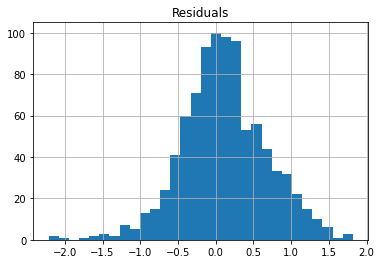

In [92]:
#Check to see if the residuals are Normally Distributed
#This check helps to determine the accuracy of the model
df_results.hist('Residuals', bins=30);

In [93]:
df_results['Residuals'].skew()

-0.10469582313380474

In [94]:
df_results[df_results['Residuals']< -2]

y_test    y_pred  y_test_transformed  y_pred_transformed  Residuals
187  2.197225  4.359508                 9.0                78.0  -2.162283
406  2.944439  4.980796                19.0               146.0  -2.036357
416  3.091042  5.306428                22.0               202.0  -2.215385

In [95]:
df_hurricane.count()[0]

1298

# Build Classification Model to Predict Community Impact
## Data Gathering
>Copy the dataframe from above

In [96]:
#Copy the dataframe from above
df_communityImpact = dfIncidentType.copy()


## Use The NOAA API to get the Precipitation and Wind Rates
> NOAA puts a 10K record limit on the number of values that can be downloaded on any one day. Therefore, this loop is used to get the data the first time, and then stored locally. 

In [97]:
# noaa_df = []
# for index, record in df_communityImpact.iterrows():
#     try:
#         GEOID = record['GEOID']
#         incidentBeginDate = record['incidentBeginDate']
#         incidentDatePlus = record['incidentdatePlus5']
#         dfNoaa = noaa_water(noaaToken, GEOID, incidentBeginDate, incidentDatePlus)
#         #print(index,GEOID, incidentBeginDate,incidentDatePlus)
#         dfNoaa = pd.pivot(dfNoaa, index=['incidentBeginDate','GEOID'], columns='datatype').reset_index()
#         noaa_df.append(dfNoaa)
#     except Exception as e:
#         continue


## Convert the values into a dataframe

In [98]:
# noaa_df = pd.DataFrame(pd.concat(noaa_df,sort = False)).reset_index(drop = True)
# #noaa_df =noaa_df.iloc[:,:10]
# # noaa_df.columns  =['incidentBeginDate','GEOID',
# #                              'PRCP','SNOW','SNWD','TMAX',
# #                              'TMIN','TOBS','WT01','WT03',
# #                              'DAPR','MDPR','SN32','SX32',
# #                              'TAVG','EVAP','WDMV','WESD',
# #                              'WESF','ADPT','ASLP','ASTP',
# #                              'AWBT','AWND','RHAV','RHMN',
# #                              'RHMX','WDF2','WDF5','WSF2',
# #                              'WSF5','MNPN', 'MXPN']

# noaa_df.head()

# Data Understanding
> Data Read-in from local

In [99]:
#noaa_df.to_csv('NoaaTotals_Updated.csv')

noaa_df = pd.read_csv('NoaaTotals_Updated.csv')

<AxesSubplot:>

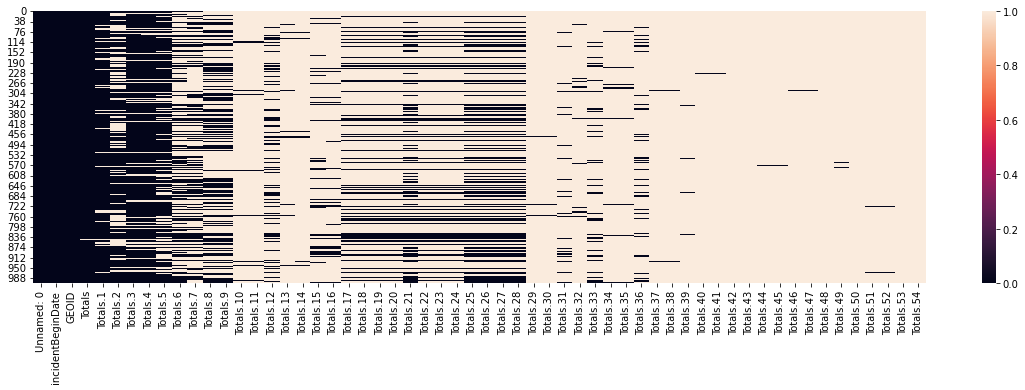

In [100]:
#noaa_df = pd.read_csv('NoaaTotals_Updated.csv',dtype={'GEOID':str})
plt.figure(figsize = [20,5])
sns.heatmap(noaa_df.isnull())

In [101]:
noaa_df.head()

Unnamed: 0 incidentBeginDate    GEOID              Totals Totals.1 Totals.2  \
0   datatype               NaN      NaN                PRCP     SNOW     SNWD   
1          0        2015-12-23  28009.0  11.149999999999999      0.0      0.0   
2          1        2015-12-23  28027.0   32.39999999999999      0.0      0.0   
3          2        2015-12-23  28093.0              18.175      NaN      NaN   
4          3        2015-12-23  28095.0  17.146666666666665      0.0      0.0   

             Totals.3            Totals.4 Totals.5 Totals.6  ... Totals.45  \
0                TMAX                TMIN     TOBS     WT01  ...      WSFG   
1   22.11666666666667                13.5     17.5      1.0  ...       NaN   
2               22.34  10.559999999999999    16.68      NaN  ...       NaN   
3   23.14166666666667  13.325000000000003      NaN      NaN  ...       NaN   
4  21.924999999999997              15.675    20.15      NaN  ...       NaN   

  Totals.46 Totals.47 Totals.48 Totals.49 Totals.50 Totals.51 Totals.52  \
0      SN33      SX33      WT06      WT04      WT09      AWDR      WSFI   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

  Totals.53 Totals.54  
0      SN53      SX53  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  

[5 rows x 58 columns]

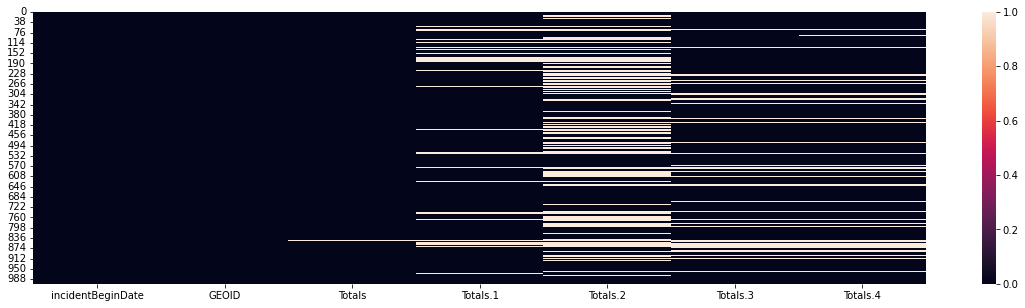

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   incidentBeginDate  1005 non-null   object 
 1   GEOID              1005 non-null   float64
 2   Totals             1001 non-null   object 
 3   Totals.1           910 non-null    object 
 4   Totals.2           640 non-null    object 
 5   Totals.3           865 non-null    object 
 6   Totals.4           864 non-null    object 
dtypes: float64(1), object(6)
memory usage: 55.1+ KB


In [102]:
#Remove mostly Null Columns
noaa_df = noaa_df.iloc[:,:8]
noaa_df = noaa_df.drop('Unnamed: 0',axis = 1, inplace = False)

plt.figure(figsize = [20,5])
sns.heatmap(noaa_df.isnull())

plt.show()
noaa_df.info()


In [103]:
#Remove columns that are mostly null. 
noaa_df = noaa_df.iloc[1:,:].reset_index(drop= True)
noaa_df.columns = ['incidentBeginDate','GEOID','PRCP','SNOW','SNWD','TMAX','TMIN']

#Review the Skew
#noaa_df.skew()#
noaa_df.head()

incidentBeginDate    GEOID                PRCP SNOW SNWD  \
0        2015-12-23  28009.0  11.149999999999999  0.0  0.0   
1        2015-12-23  28027.0   32.39999999999999  0.0  0.0   
2        2015-12-23  28093.0              18.175  NaN  NaN   
3        2015-12-23  28095.0  17.146666666666665  0.0  0.0   
4        2015-12-23  28107.0               20.65  0.0  0.0   

                 TMAX                TMIN  
0   22.11666666666667                13.5  
1               22.34  10.559999999999999  
2   23.14166666666667  13.325000000000003  
3  21.924999999999997              15.675  
4  24.349999999999998  13.999999999999998

In [104]:
#Convert the GEOID from a float to an string.
noaa_df['GEOID'] = noaa_df['GEOID'].astype(str).str.strip('.0')

#The average precipitation is the variable that has the most impact on the outcome. 
noaa_df = noaa_df[['incidentBeginDate','GEOID','PRCP']]
#The values are skewed. Log Transform for a smaller skew
noaa_df['PRCP'] = np.log([x+1 for x in noaa_df['PRCP'].astype(float)])
noaa_df.head()

incidentBeginDate  GEOID      PRCP
0        2015-12-23  28009  2.497329
1        2015-12-23  28027  3.508556
2        2015-12-23  28093  2.953607
3        2015-12-23  28095  2.898487
4        2015-12-23  28107  3.075005

## Combine the datasets together

In [105]:
#Ensure data is structured correctly then merge
df_communityImpact['GEOID'] = df_communityImpact['GEOID'].astype(str)
noaa_df['GEOID'] = noaa_df['GEOID'].astype(str)

df_communityImpact['incidentBeginDate'] = pd.to_datetime(df_communityImpact['incidentBeginDate']).dt.strftime('%Y-%m-%d')

# #Removed because high p-value, and reduced dataset by 1/3
df_communityImpact = pd.merge(df_communityImpact,noaa_df
                       ,on  = ['GEOID','incidentBeginDate']
                       ,how = 'left'
                       ,suffixes = ['_FEMA','_NOAA']
                       )

df_communityImpact.head()

disasterNumber state             county  totalValidRegistrations  \
0            4248    MS    Benton (County)                      159   
1            4248    MS   Coahoma (County)                      271   
2            4248    MS  Marshall (County)                      378   
3            4248    MS    Monroe (County)                       89   
4            4248    MS    Panola (County)                       46   

   ihpEligible   ihpAmount  incidentType incidentBeginDate    yr  year  ...  \
0           44   443296.26  Severe Storm        2015-12-23  2016  2016  ...   
1           57   296059.98  Severe Storm        2015-12-23  2016  2016  ...   
2          101  1067090.66  Severe Storm        2015-12-23  2016  2016  ...   
3           46   307400.29  Severe Storm        2015-12-23  2016  2016  ...   
4           10    30547.65  Severe Storm        2015-12-23  2016  2016  ...   

   S2201_C05_033E S2201_C05_034E  S2201_C05_035E  S2201_C05_036E  \
0          1727.0        41385.0          1856.0           395.0   
1          2211.0        38920.0          3339.0           558.0   
2          6091.0        44271.0          7844.0          1329.0   
3          8577.0        45406.0          7801.0          1505.0   
4          6021.0        44873.0          6592.0          1395.0   

   S2201_C05_037E  S2201_C05_038E  disasterSize  communityImpact cluster  \
0           757.0           704.0             0           Medium       0   
1          1337.0          1444.0             0           Medium       0   
2          2996.0          3519.0             0           Medium       0   
3          2656.0          3640.0             0         Very Low       0   
4          2363.0          2834.0             0         Very Low       0   

       PRCP  
0  2.497329  
1  3.508556  
2  2.953607  
3  2.898487  
4  3.075005  

[5 rows x 142 columns]

# Data Prep

## Create the Community Impact Calculation

In [106]:
#Remove the cluster column, create the month date and read out the values for inspection
# df_communityImpact = df_communityImpact.drop('cluster',axis = 1) 
df_communityImpact['Month'] = df_communityImpact['incidentBeginDate'].astype(str).str.slice(start=5, stop=7)
df_communityImpact.head()

disasterNumber state             county  totalValidRegistrations  \
0            4248    MS    Benton (County)                      159   
1            4248    MS   Coahoma (County)                      271   
2            4248    MS  Marshall (County)                      378   
3            4248    MS    Monroe (County)                       89   
4            4248    MS    Panola (County)                       46   

   ihpEligible   ihpAmount  incidentType incidentBeginDate    yr  year  ...  \
0           44   443296.26  Severe Storm        2015-12-23  2016  2016  ...   
1           57   296059.98  Severe Storm        2015-12-23  2016  2016  ...   
2          101  1067090.66  Severe Storm        2015-12-23  2016  2016  ...   
3           46   307400.29  Severe Storm        2015-12-23  2016  2016  ...   
4           10    30547.65  Severe Storm        2015-12-23  2016  2016  ...   

   S2201_C05_034E S2201_C05_035E  S2201_C05_036E  S2201_C05_037E  \
0         41385.0         1856.0           395.0           757.0   
1         38920.0         3339.0           558.0          1337.0   
2         44271.0         7844.0          1329.0          2996.0   
3         45406.0         7801.0          1505.0          2656.0   
4         44873.0         6592.0          1395.0          2363.0   

   S2201_C05_038E  disasterSize  communityImpact  cluster      PRCP Month  
0           704.0             0           Medium        0  2.497329    12  
1          1444.0             0           Medium        0  3.508556    12  
2          3519.0             0           Medium        0  2.953607    12  
3          3640.0             0         Very Low        0  2.898487    12  
4          2834.0             0         Very Low        0  3.075005    12  

[5 rows x 143 columns]

In [107]:
df_communityImpact['GEOID'] = df_communityImpact['GEOID'].astype(str)
df_communityImpact['yr'] = df_communityImpact['yr'].astype(str)


## Look at records that are null, which will need to be imputed

In [108]:
df_communityImpact[df_communityImpact['PRCP'].isnull()]['state'].value_counts()
# df_communityImpact

PR    210
AR     45
AL     24
IN     22
MS     17
GA     14
KY     10
LA      9
VA      7
AK      6
CT      3
FL      2
OK      2
WV      2
TN      2
WI      1
SC      1
SD      1
OR      1
NY      1
MO      1
Name: state, dtype: int64

In [109]:
#Drop Columns that will not be used later in the modeling
df_impact = df_communityImpact.drop( ['st_cd','state'
                                     ,'county','yr'
                                     ,'Fips_county','incidentdatePlus3'
                                     ,'incidentdatePlus5','GEO_ID'
                                     ,'GEOID','totalValidRegistrations'
                                     ,'incidentBeginDate', 'year'
                                     ],axis = 1
                                   )

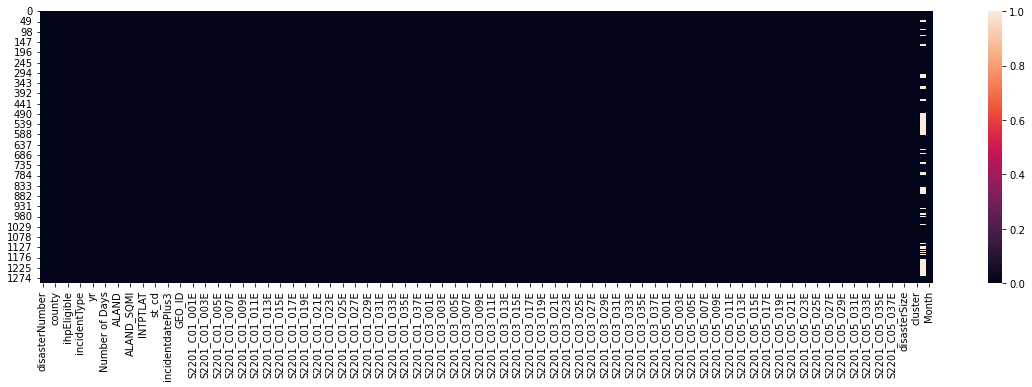

1298


In [110]:
#Review the output: Precipitation will need to be imputed.
plt.figure(figsize = [20,5])
sns.heatmap(df_communityImpact.isnull())
plt.show();
print(df_impact.count()[0])

In [111]:
#Understand the delta in the number of records between the two 
len(noaa_df['PRCP'])

1005

## Clean Data

In [112]:
#Reduce skew with a log transfoormation
for col in df_impact.columns:
    try:
        #Precipitation is already log-transformed
        if  col in['Rural_Urban','communityImpact','INTPTLAT','Month','communityImpact'\
                   ,'disasterSize','INTPTLONG','Month','state','disasterSize','PRCP']:
            continue
        elif 'incidentType' in col or 'timeToDeclaration' in col:
            continue
        else:
            df_impact[col] = np.log([x+1 for x in df_impact.loc[:,col].astype(float)])
    except Exception as e:
        print(e)


# df_impact.head()
df_impact

could not convert string to float: 'Benton County, Mississippi'


disasterNumber  ihpEligible  ihpAmount  incidentType  Number of Days  \
0           8.354439     3.806662  13.001996  Severe Storm        2.564949   
1           8.354439     4.060443  12.598321  Severe Storm        2.564949   
2           8.354439     4.624973  13.880447  Severe Storm        2.564949   
3           8.354439     3.850148  12.635909  Severe Storm        2.564949   
4           8.354439     2.397895  10.327076  Severe Storm        2.564949   
...              ...          ...        ...           ...             ...   
1293        8.451267     4.343805  12.559448     Hurricane        3.610918   
1294        8.451267     3.135494  11.020048     Hurricane        3.610918   
1295        8.451267     3.610918  11.373535     Hurricane        3.610918   
1296        8.451267     3.332205  11.306060     Hurricane        3.610918   
1297        8.451267     6.091310  14.241557     Hurricane        3.610918   

          ALAND     AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  ...  \
0     20.775034  15.479282    6.010326     1.111199  34.810518  ...   
1     21.081664  18.189033    6.316309     3.454011  34.228670  ...   
2     21.327030  16.034191    6.561281     1.515127  34.766190  ...   
3     21.407161  16.713521    6.641304     2.079816  33.890030  ...   
4     21.296792  17.762317    6.531086     3.043951  34.365205  ...   
...         ...        ...         ...          ...        ...  ...   
1293  20.953766  19.205530    6.188656     4.450117  29.474891  ...   
1294  21.625519  20.089983    6.859405     5.327687  28.764113  ...   
1295  21.357951  19.357898    6.592159     4.600831  29.593896  ...   
1296  21.165161  20.164848    6.399661     5.402200  29.890487  ...   
1297  21.771243  20.570254    7.004987     5.806104  29.057769  ...   

      S2201_C05_034E S2201_C05_035E  S2201_C05_036E  S2201_C05_037E  \
0          10.630698       7.526718        5.981414        6.630683   
1          10.569289       8.113726        6.326149        7.198931   
2          10.698108       8.967632        7.192934        8.005367   
3          10.723422       8.962135        7.317212        7.884953   
4          10.711614       8.793764        7.241366        7.768110   
...              ...            ...             ...             ...   
1293       11.095135      10.307952        9.210140        8.993676   
1294       11.073816      11.429620       10.103772       10.145767   
1295       10.729131       9.541872        8.203304        8.552753   
1296       11.436627      11.124376        9.446519        9.950610   
1297       11.030509      11.710242       10.292891       10.559737   

      S2201_C05_038E  disasterSize  communityImpact   cluster      PRCP  Month  
0           6.558198             0           Medium  0.000000  2.497329     12  
1           7.275865             0           Medium  0.000000  3.508556     12  
2           8.166216             0           Medium  0.000000  2.953607     12  
3           8.200014             0         Very Low  0.000000  2.898487     12  
4           7.949797             0         Very Low  0.000000  3.075005     12  
...              ...           ...              ...       ...       ...    ...  
1293        9.386141             0              Low  0.000000  2.517015     11  
1294       10.647589             0         Very Low  0.000000  2.694688     11  
1295        8.536800             0              Low  0.000000  2.685176     11  
1296       10.439308             0         Very Low  0.000000  2.858703     11  
1297       10.891950             0              Low  1.609438  2.977967     11  

[1298 rows x 131 columns]

In [113]:
for n,column in enumerate(df_impact.columns):
    print(n,column)

0 disasterNumber
1 ihpEligible
2 ihpAmount
3 incidentType
4 Number of Days
5 ALAND
6 AWATER
7 ALAND_SQMI
8 AWATER_SQMI
9 INTPTLAT
10 INTPTLONG
11 NAME
12 S2201_C01_001E
13 S2201_C01_002E
14 S2201_C01_003E
15 S2201_C01_004E
16 S2201_C01_005E
17 S2201_C01_006E
18 S2201_C01_007E
19 S2201_C01_008E
20 S2201_C01_009E
21 S2201_C01_010E
22 S2201_C01_011E
23 S2201_C01_012E
24 S2201_C01_013E
25 S2201_C01_014E
26 S2201_C01_015E
27 S2201_C01_016E
28 S2201_C01_017E
29 S2201_C01_018E
30 S2201_C01_019E
31 S2201_C01_020E
32 S2201_C01_021E
33 S2201_C01_022E
34 S2201_C01_023E
35 S2201_C01_024E
36 S2201_C01_025E
37 S2201_C01_026E
38 S2201_C01_027E
39 S2201_C01_028E
40 S2201_C01_029E
41 S2201_C01_030E
42 S2201_C01_031E
43 S2201_C01_032E
44 S2201_C01_033E
45 S2201_C01_034E
46 S2201_C01_035E
47 S2201_C01_036E
48 S2201_C01_037E
49 S2201_C01_038E
50 S2201_C03_001E
51 S2201_C03_002E
52 S2201_C03_003E
53 S2201_C03_004E
54 S2201_C03_005E
55 S2201_C03_006E
56 S2201_C03_007E
57 S2201_C03_008E
58 S2201_C03_009E
59 

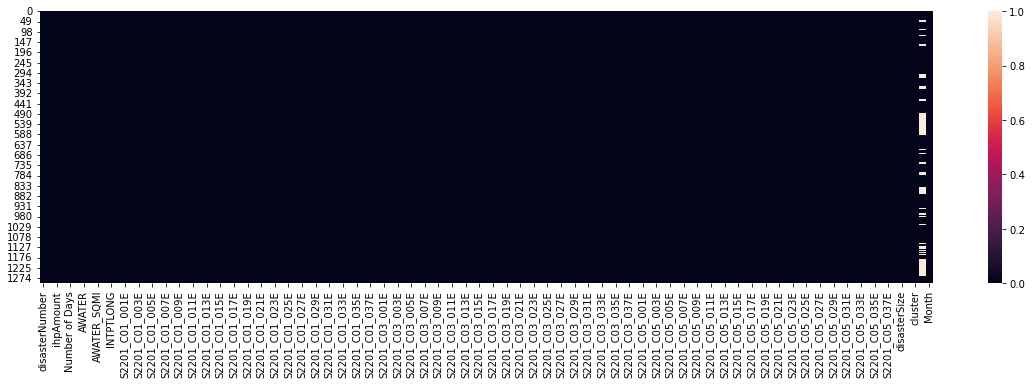

In [114]:
plt.figure(figsize= [20,5])
sns.heatmap(df_impact.isnull());


In [115]:
#Drop Columns that do not impact the output or are categorical
df_impact.drop('NAME', axis = 1, inplace = True)


df_impact

disasterNumber  ihpEligible  ihpAmount  incidentType  Number of Days  \
0           8.354439     3.806662  13.001996  Severe Storm        2.564949   
1           8.354439     4.060443  12.598321  Severe Storm        2.564949   
2           8.354439     4.624973  13.880447  Severe Storm        2.564949   
3           8.354439     3.850148  12.635909  Severe Storm        2.564949   
4           8.354439     2.397895  10.327076  Severe Storm        2.564949   
...              ...          ...        ...           ...             ...   
1293        8.451267     4.343805  12.559448     Hurricane        3.610918   
1294        8.451267     3.135494  11.020048     Hurricane        3.610918   
1295        8.451267     3.610918  11.373535     Hurricane        3.610918   
1296        8.451267     3.332205  11.306060     Hurricane        3.610918   
1297        8.451267     6.091310  14.241557     Hurricane        3.610918   

          ALAND     AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  ...  \
0     20.775034  15.479282    6.010326     1.111199  34.810518  ...   
1     21.081664  18.189033    6.316309     3.454011  34.228670  ...   
2     21.327030  16.034191    6.561281     1.515127  34.766190  ...   
3     21.407161  16.713521    6.641304     2.079816  33.890030  ...   
4     21.296792  17.762317    6.531086     3.043951  34.365205  ...   
...         ...        ...         ...          ...        ...  ...   
1293  20.953766  19.205530    6.188656     4.450117  29.474891  ...   
1294  21.625519  20.089983    6.859405     5.327687  28.764113  ...   
1295  21.357951  19.357898    6.592159     4.600831  29.593896  ...   
1296  21.165161  20.164848    6.399661     5.402200  29.890487  ...   
1297  21.771243  20.570254    7.004987     5.806104  29.057769  ...   

      S2201_C05_034E  S2201_C05_035E  S2201_C05_036E  S2201_C05_037E  \
0          10.630698        7.526718        5.981414        6.630683   
1          10.569289        8.113726        6.326149        7.198931   
2          10.698108        8.967632        7.192934        8.005367   
3          10.723422        8.962135        7.317212        7.884953   
4          10.711614        8.793764        7.241366        7.768110   
...              ...             ...             ...             ...   
1293       11.095135       10.307952        9.210140        8.993676   
1294       11.073816       11.429620       10.103772       10.145767   
1295       10.729131        9.541872        8.203304        8.552753   
1296       11.436627       11.124376        9.446519        9.950610   
1297       11.030509       11.710242       10.292891       10.559737   

      S2201_C05_038E  disasterSize  communityImpact   cluster      PRCP  Month  
0           6.558198             0           Medium  0.000000  2.497329     12  
1           7.275865             0           Medium  0.000000  3.508556     12  
2           8.166216             0           Medium  0.000000  2.953607     12  
3           8.200014             0         Very Low  0.000000  2.898487     12  
4           7.949797             0         Very Low  0.000000  3.075005     12  
...              ...           ...              ...       ...       ...    ...  
1293        9.386141             0              Low  0.000000  2.517015     11  
1294       10.647589             0         Very Low  0.000000  2.694688     11  
1295        8.536800             0              Low  0.000000  2.685176     11  
1296       10.439308             0         Very Low  0.000000  2.858703     11  
1297       10.891950             0              Low  1.609438  2.977967     11  

[1298 rows x 130 columns]

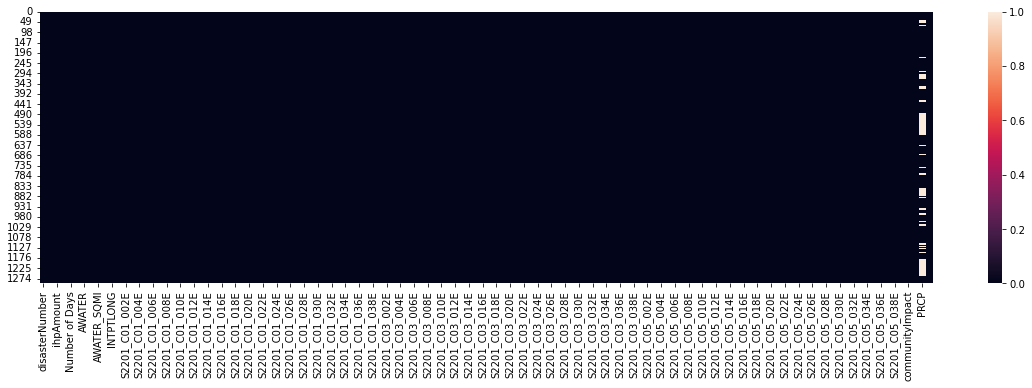

In [116]:
plt.figure(figsize= [20,5])
sns.heatmap(df_impact.isnull()); 

In [117]:
df_impact = pd.get_dummies(df_impact, columns = ['incidentType'#,'timeToDeclaration'
                                                 ,'Month'], drop_first = True)
# df_impact['disasterSize']

# Modeling

## Impute the Values for the Precipitation Rates
> Assign X and y values for train-test split

In [118]:
from sklearn.impute import SimpleImputer
knnImpute = KNNImputer(n_neighbors = 5)

# df_impact.dropna(axis=0,inplace = True)

X = df_impact.drop(['communityImpact','disasterNumber','ihpAmount'
                    ,'ihpEligible'], axis = 1)
cols = X.columns
X = knnImpute.fit_transform(X)
X = pd.DataFrame(X, columns = cols)
y = df_impact['communityImpact']#.values.reshape(-1,1)


In [119]:
# X['PRCP'] = np.log(X['PRCP'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [120]:
for col in X.columns:
    print(col)

Number of Days
ALAND
AWATER
ALAND_SQMI
AWATER_SQMI
INTPTLAT
INTPTLONG
S2201_C01_001E
S2201_C01_002E
S2201_C01_003E
S2201_C01_004E
S2201_C01_005E
S2201_C01_006E
S2201_C01_007E
S2201_C01_008E
S2201_C01_009E
S2201_C01_010E
S2201_C01_011E
S2201_C01_012E
S2201_C01_013E
S2201_C01_014E
S2201_C01_015E
S2201_C01_016E
S2201_C01_017E
S2201_C01_018E
S2201_C01_019E
S2201_C01_020E
S2201_C01_021E
S2201_C01_022E
S2201_C01_023E
S2201_C01_024E
S2201_C01_025E
S2201_C01_026E
S2201_C01_027E
S2201_C01_028E
S2201_C01_029E
S2201_C01_030E
S2201_C01_031E
S2201_C01_032E
S2201_C01_033E
S2201_C01_034E
S2201_C01_035E
S2201_C01_036E
S2201_C01_037E
S2201_C01_038E
S2201_C03_001E
S2201_C03_002E
S2201_C03_003E
S2201_C03_004E
S2201_C03_005E
S2201_C03_006E
S2201_C03_007E
S2201_C03_008E
S2201_C03_009E
S2201_C03_010E
S2201_C03_011E
S2201_C03_012E
S2201_C03_013E
S2201_C03_014E
S2201_C03_015E
S2201_C03_016E
S2201_C03_017E
S2201_C03_018E
S2201_C03_019E
S2201_C03_020E
S2201_C03_021E
S2201_C03_022E
S2201_C03_023E
S2201_C03_024E


In [121]:

# sns.heatmap(confusion_matrix(y_test,y_pred),cmap = 'coolwarm', annot = True)
# for col in X_train.columns:
#     print(col)

## Investigate Elements

In [122]:
rfc = RFC()
rfc.fit(X_train,y_train)


RandomForestClassifier()

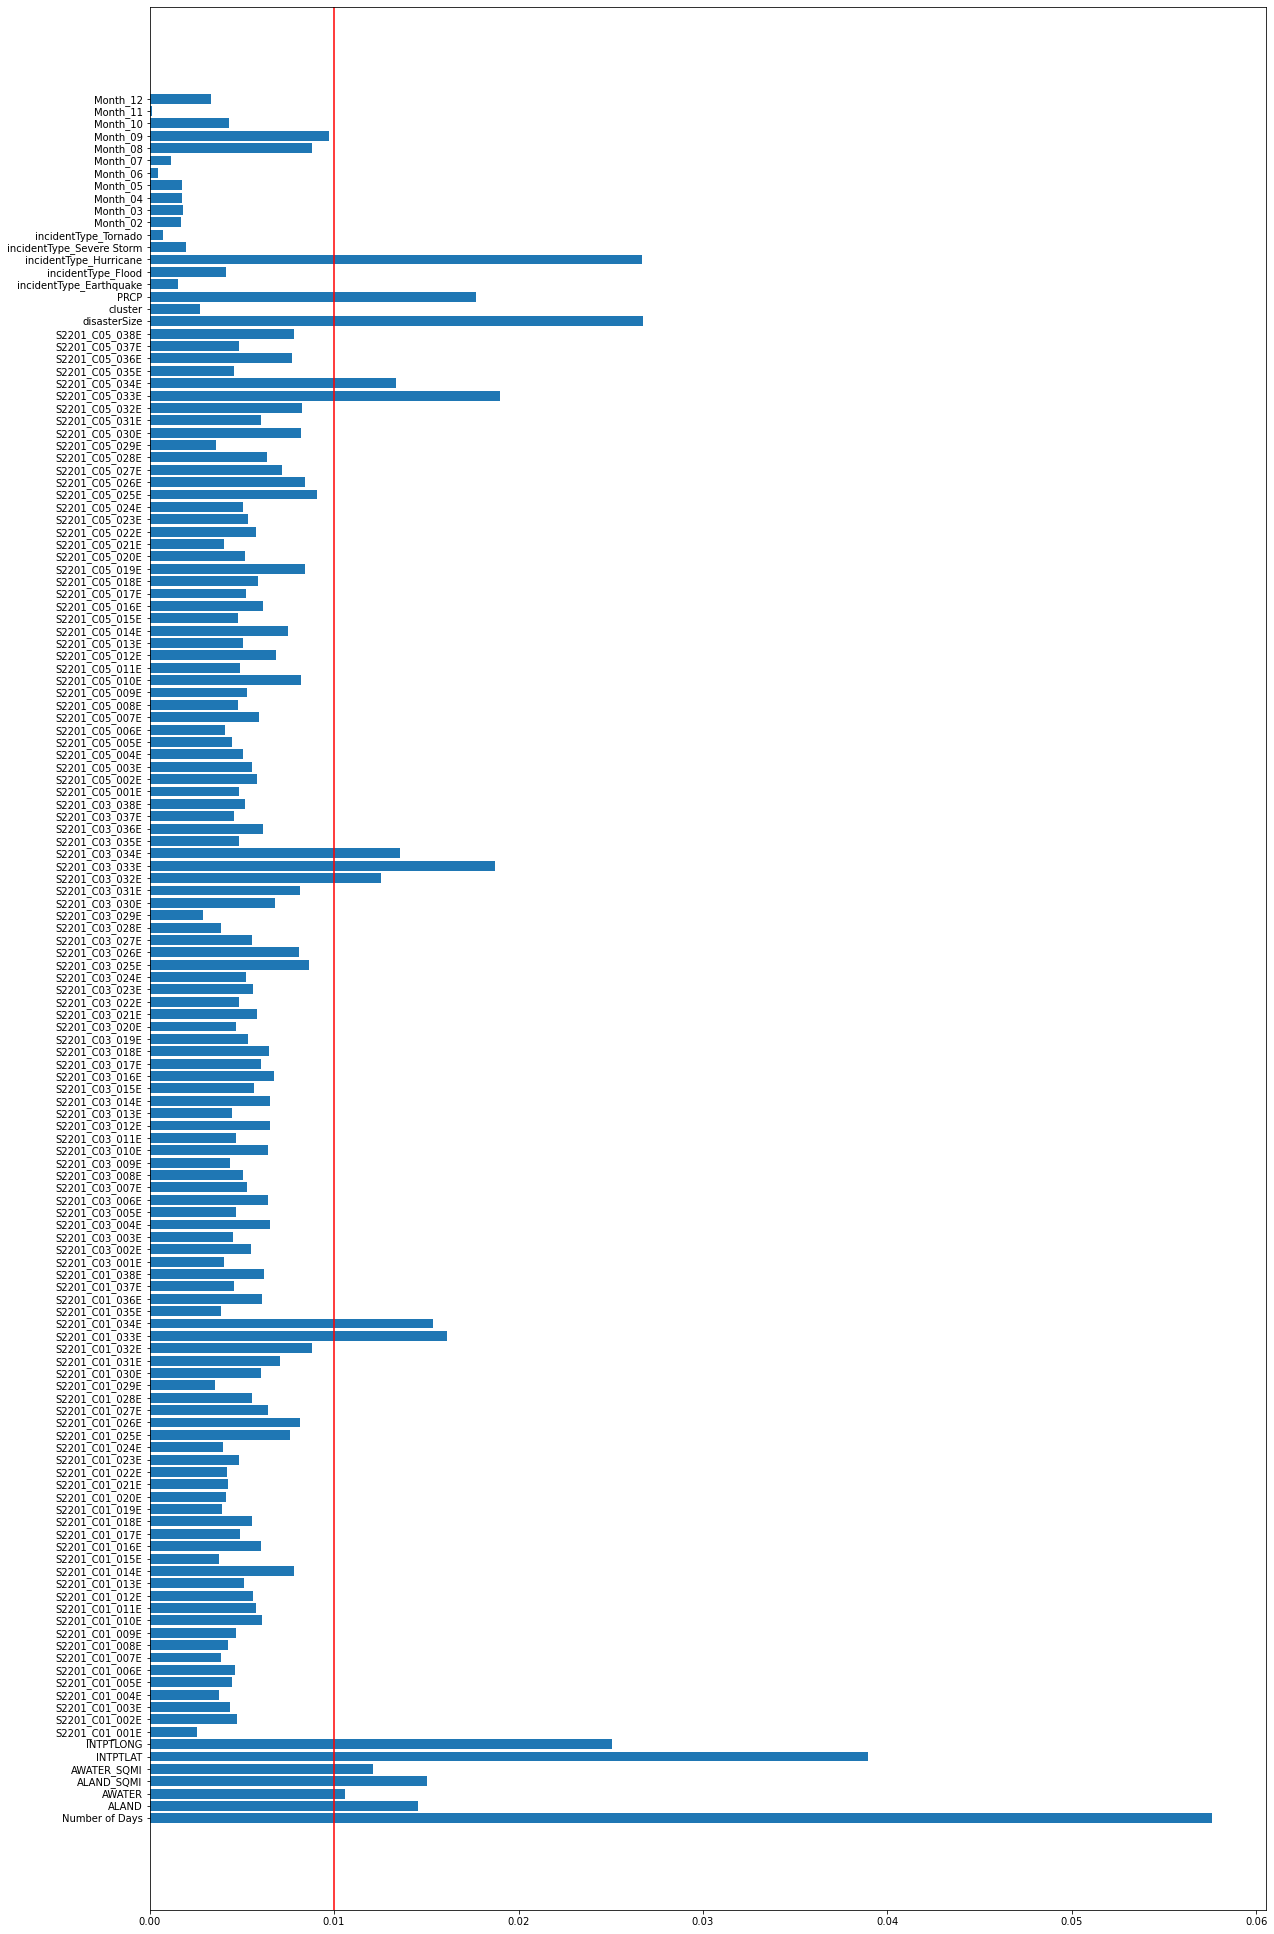

In [123]:
plt.figure(figsize = [20,35])
#Visually inspect the feature importances
names = X_train.columns
plt.barh(names,rfc.feature_importances_)
plt.axvline(x = 0.01,color ='red');



In [124]:
# rfc.feature_importances_
X['disasterSize']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1293    0.0
1294    0.0
1295    0.0
1296    0.0
1297    0.0
Name: disasterSize, Length: 1298, dtype: float64

In [125]:
#C
features = pd.DataFrame(zip(names,rfc.feature_importances_), columns = ['columns','values'])
features = features[features['values']>=0.01]#0.086
features

columns    values
0            Number of Days  0.057614
1                     ALAND  0.014525
2                    AWATER  0.010586
3                ALAND_SQMI  0.015035
4               AWATER_SQMI  0.012127
5                  INTPTLAT  0.038919
6                 INTPTLONG  0.025060
39           S2201_C01_033E  0.016131
40           S2201_C01_034E  0.015382
76           S2201_C03_032E  0.012549
77           S2201_C03_033E  0.018728
78           S2201_C03_034E  0.013570
115          S2201_C05_033E  0.018998
116          S2201_C05_034E  0.013342
121            disasterSize  0.026730
123                    PRCP  0.017678
126  incidentType_Hurricane  0.026712

In [126]:
features = ['ALAND_SQMI'
            ,'AWATER_SQMI'
            #,'S2201_C05_002E'
            ,'S2201_C05_034E'
            #,'S2201_C05_032E'
            #,'S2201_C03_033E'
            ,'Number of Days'
            ,'INTPTLAT'
            ,'INTPTLONG'
            ,'PRCP'
            
            #Incident Begin Month
            ,'Month_02'
            ,'Month_03'
            ,'Month_04','Month_05'
            ,'Month_06','Month_07'
            ,'Month_08','Month_09'
            ,'Month_10','Month_11'
            ,'Month_12'
            #Incident Type
            ,'incidentType_Earthquake'
            ,'incidentType_Flood'
            ,'incidentType_Hurricane'
            ,'incidentType_Severe Storm'
            ,'incidentType_Tornado'
            #Number of days to the incident
            #,'timeToDeclaration_Small'
           
            #This is a proxy for Critical Needs Assistance
            #,'disasterSize'

            
            ##Tested but identified Multi-Collinearity
            #,'TOBS',
            #,'S2201_C03_033E'
            #,Evaluated, but didn't return better results
            #'TMIN'
            #,'S1501_C01_032E'#	0.007081
            #,'S1501_C01_033E'#	0.006841
            #,S1501_C01_035E	0.005459
            #,'S1501_C03_031E'#	0.007481
            #,'S1501_C03_032E'#	0.007800
            #,'S1501_C03_033E'#	0.008455
            #,'S1501_C03_034E	0.005282
            #,'S1501_C05_031E'
            #,'S1603_C03_002E'
            #,'S1603_C03_004E'
        
            #Estimate!!Owner-occupied housing units!!Occupied housing units!!
            #RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!
            #One race --!!Black or African American
            #,'S2502_C03_003E'
           ]

In [127]:
knnImpute = KNNImputer(n_neighbors = 5)
# df_impact = df_impact[df_impact['incidentType_Hurricane']==1]
X = df_impact.drop(['communityImpact','disasterNumber'], axis = 1)
cols = X.columns

X = knnImpute.fit_transform(X)
y = df_impact['communityImpact']#.values.reshape(-1,1)

X = pd.DataFrame(X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Check for Multi-Collinearity

In [128]:
X = X[features]
X.columns = features
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

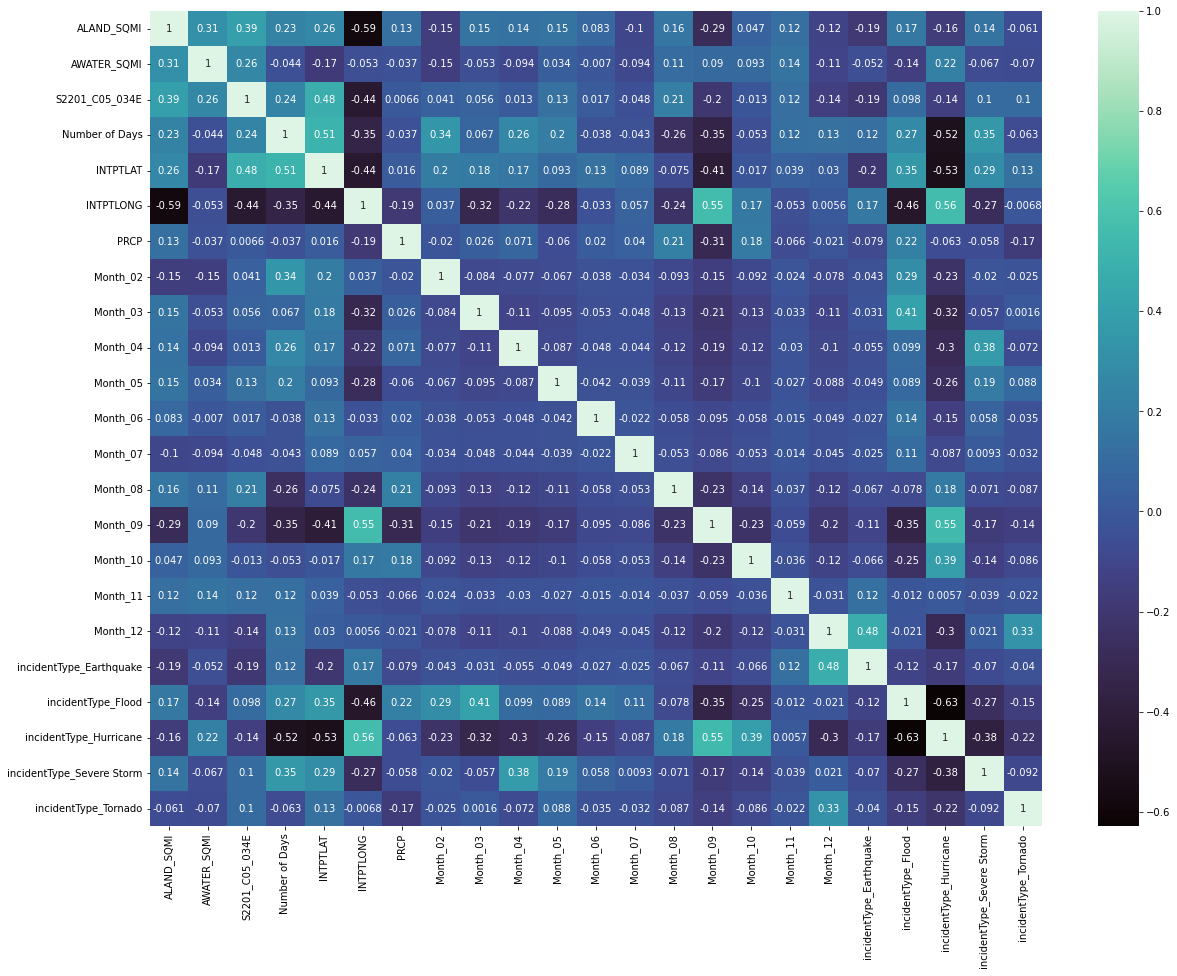

In [129]:
plt.figure(figsize = [20,15])
sns.heatmap(X.corr(method = 'spearman'),cmap='mako', annot = True);

In [130]:
X.columns

Index(['ALAND_SQMI', 'AWATER_SQMI', 'S2201_C05_034E', 'Number of Days',
       'INTPTLAT', 'INTPTLONG', 'PRCP', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'Month_09', 'Month_10',
       'Month_11', 'Month_12', 'incidentType_Earthquake', 'incidentType_Flood',
       'incidentType_Hurricane', 'incidentType_Severe Storm',
       'incidentType_Tornado'],
      dtype='object')

# Modeling
## Community Impact Classification
> Five Fold Cross Validation

In [131]:
#Hyper Parameter Tuning
n_estimators = [10,100,1000]#,10000]
max_features = ['auto','sqrt']
max_depth    = [None,2,4,6]
min_samples_split = [2,3,4]
min_samples_leaf = [1,2,3]
bootstrap = [True,False]
criterion = ['gini','entropy']


params = {'n_estimators':n_estimators
             ,'max_features':max_features
             ,'max_depth':max_depth
             ,'min_samples_split':min_samples_split
             ,'min_samples_leaf':min_samples_leaf
             ,'bootstrap':bootstrap
             ,'criterion':criterion
         }


In [132]:
random_rfc = RFC()
rfc_rcv = RandomizedSearchCV(estimator = random_rfc, param_distributions = params
                            , verbose = 1,cv = 25, n_jobs = -1)
# rfc.fit(X_train,y_train)
# y_pred_rfc = rfc.predict(X_test)

rfc_rcv.fit(X_train,y_train)
y_pred_rfc = rfc_rcv.predict(X_test)

#Best Parameters Random Forest
param = rfc_rcv.best_params_
param

##Tuned Results perform worse than default RFC
# Fitting 25 folds for each of 10 candidates, totalling 250 fits
# Out[321]:
# {'n_estimators': 100,
#  'min_samples_split': 4,
#  'min_samples_leaf': 3,
#  'max_features': 'sqrt',
#  'max_depth': 6,
#  'criterion': 'entropy',
#  'bootstrap': False}

Fitting 25 folds for each of 10 candidates, totalling 250 fits


{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

## Five Fold Cross Validation

In [133]:

# grid_rfc = RFC()
# rfc_grid = GridSearchCV(estimator = grid_rfc, param_grid = params
#                             , verbose = 2,cv = 5, return_train_score=True)
# rfc_grid.fit(X_train,y_train)
# y_pred_rfc = rfc_grid.predict(X_test)

In [134]:
#5-Fold Cross Validation output

# param = rfc_grid.best_params_
# param
# param = {'bootstrap': False,
#  'criterion': 'entropy',
#  'max_depth': 6,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 2,
#  'n_estimators': 10}

# param = {'n_estimators': 100,
#          'min_samples_split': 2,
#          'min_samples_leaf': 2,
#          'max_features': 'auto',
#          'max_depth': 6,
#          'criterion': 'entropy',
#          'bootstrap': True
#         }

# Evaluation
## Optimized Random Forest


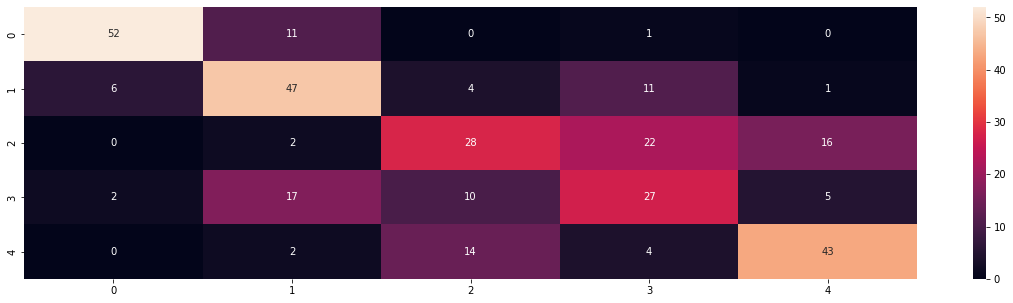

In [135]:
plt.figure(figsize = [20,5])

# rfc = RFC(n_estimators = param['n_estimators']
#          ,min_samples_split = param['min_samples_split']
#          ,min_samples_leaf = param['min_samples_leaf']
#          ,max_features = param['max_features']
#          ,max_depth = param['max_depth']
#          ,bootstrap = param['bootstrap']
#          ,criterion = param['criterion']
#          )

rfc = RFC()
# # rfc = make_pipeline(StandardScaler(),rfc)

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

#RandomForestClassifier
sns.heatmap(confusion_matrix(y_test,y_pred),cmap = 'rocket', annot = True);

In [136]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred,average = 'macro')

print('Random Forest')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

Random Forest
The accuracy score is 0.61
The precision score is 0.61
The recall score is 0.61
The f1 score is 0.61


## Inspect the Dataset
> For those that do not match, look at the predicted probabilities

In [137]:
df_ = X_test.copy()
df_['y_test'] = y_test
df_['y_pred'] = y_pred
df_['y_pred_proba'] = list(rfc.predict_proba(X_test))

classes = str(rfc.classes_)
df_['classes'] = classes
df_.head(50)

ALAND_SQMI  AWATER_SQMI  S2201_C05_034E  Number of Days   INTPTLAT  \
994     5.154262     1.213428       11.165451        4.025352  37.873291   
578     6.214250     4.858501       11.015690        4.382027  41.472247   
1163    6.451762     2.164242       10.795076        4.077537  35.158366   
722     6.018754     1.937734       10.532603        4.110874  33.659670   
561     3.601059     0.875052       10.316822        1.386294  18.130718   
629     5.909642     1.877019       10.845641        2.079442  35.700357   
898     6.210480     2.822033       10.896109        2.995732  34.885368   
1006    5.945753     1.297463       10.829253        4.025352  37.922940   
346     6.446575     1.132047       10.581343        3.583519  36.648902   
1003    6.083034     1.931956       11.001016        4.025352  37.725511   
809     6.279090     1.981001       10.851974        4.276666  39.778587   
115     6.121780     3.298685       10.594683        2.833213  34.652201   
755     6.031944     2.285541       10.996568        3.258097  36.704380   
1113    6.577180     2.019293       10.826694        1.098612  36.892059   
989     5.651215     1.064711       11.096167        4.025352  38.040678   
770     6.315857     2.735211       10.808394        2.944439  35.265702   
538     3.963856     3.072647       10.208027        1.386294  18.211070   
1172    5.734774     0.538830       10.548075        1.386294  37.698983   
1217    4.030890     3.625380       10.227634        1.609438  18.483983   
618     6.637181     4.971569       10.879499        2.079442  34.763109   
1164    6.347811     2.866421       11.102367        4.077537  36.120318   
1000    5.996171     1.507405       10.551820        4.025352  37.087846   
1153    3.846908     3.149611       10.447816        3.988984  18.455128   
843     3.695979     1.893112       10.348398        2.995732  18.286905   
365     6.481942     1.569449       10.653369        3.931826  36.341298   
44      6.475297     2.842639       10.929440        3.737670  35.146286   
532     3.831680     3.278879       10.296610        1.386294  18.444803   
1213    3.363322     0.356275       10.728715        1.609438  18.272581   
533     3.627589     0.004988       10.067560        1.386294  18.173956   
803     6.406081     2.551474       11.018055        4.276666  39.005336   
1257    4.029184     3.368261       10.365648        1.609438  18.059858   
930     7.134351     3.855008       10.596185        1.945910  31.732509   
1093    6.405835     2.917122       11.553088        2.397895  40.336887   
398     6.845513     3.467079       10.811000        1.098612  30.752932   
101     6.777160     3.409298       10.489050        2.833213  33.799139   
513     2.785567     0.012916       10.094934        1.386294  18.369006   
244     6.418906     6.742535       10.943623        1.945910  35.408157   
667     5.567970     2.184702       10.796244        1.791759  31.457003   
602     6.844939     2.883795       10.679481        2.079442  34.261602   
394     6.670096     2.716878       10.907698        1.098612  30.543231   
1008    5.831011     1.362770       10.900621        4.025352  37.241282   
76      5.966377     2.657038       10.723862        1.791759  32.101213   
296     6.065284     1.306710       11.025540        3.761200  44.015261   
996     5.865102     0.847155       10.628690        4.025352  37.354368   
715     6.083205     1.437463       11.263733        2.484907  41.033703   
220     6.052903     5.014282       10.817115        1.609438  31.488592   
65      6.438687     2.472581       10.657495        1.791759  32.139076   
1224    3.551914     0.012916       10.480382        1.609438  18.187148   
1236    3.862917     3.387673       10.235378        1.609438  18.000311   
1053    6.324135     3.540408       10.949261        1.386294  30.708319   

      INTPTLONG      PRCP  Month_02  Month_03  Month_04  ...  Month_12  \
994  -84.583960  2.696652       1.0       0.0       0.0

## DECISION TREE CLASSIFER

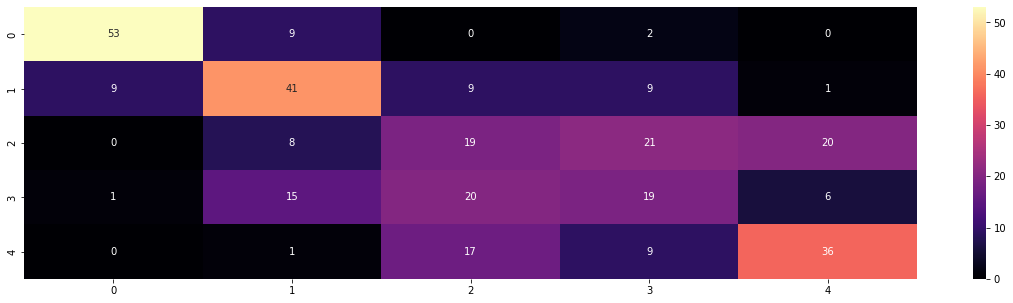

In [138]:


# decTree= DTC(criterion = param['criterion']
#             ,max_depth = param['max_depth']
#             ,min_samples_split =  param['min_samples_split']
#             ,min_samples_leaf = param['min_samples_leaf']
#             ,max_features = param['max_features']
#             )
decTree = DTC()
decTree.fit(X_train,y_train)
y_pred_dec = decTree.predict(X_test)
plt.figure(figsize = [20,5])

#DecisionTreeClassifier
sns.heatmap(confusion_matrix(y_test,y_pred_dec),cmap = 'magma', annot = True);

In [139]:
accuracy = accuracy_score(y_test,y_pred_dec)
precision = precision_score(y_test,y_pred_dec,average='macro')
recall = recall_score(y_test,y_pred_dec,average='macro')
f1 = f1_score(y_test,y_pred_dec,average = 'macro')

print('Decision Tree')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))
# print(rfc.decision_path(X_train))

Decision Tree
The accuracy score is 0.52
The precision score is 0.52
The recall score is 0.52
The f1 score is 0.52


## LOGISTIC REGRESSION

In [140]:
# logreg = LogisticRegression()
pipel = make_pipeline(StandardScaler()
                      #multi_class{‘auto’, ‘ovr’, ‘multinomial’}
                     ,LogisticRegression(penalty= 'l1',solver = 'liblinear'
                                        , max_iter = 1000, multi_class = 'ovr'
                                        )
                     )
pipel.fit(X_train,y_train)
y_predl = pipel.predict(X_test)


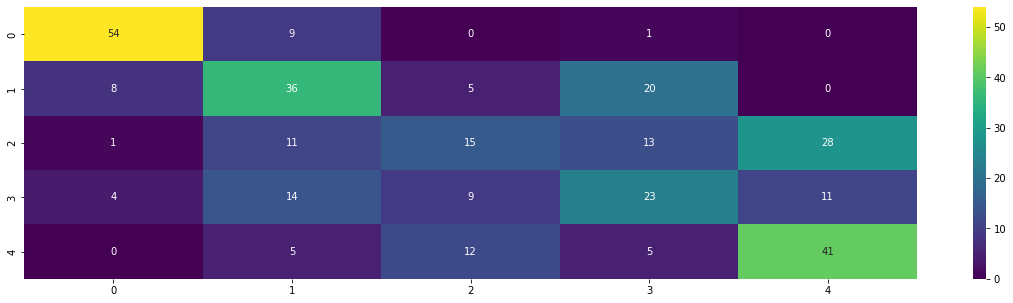

In [141]:
plt.figure(figsize = [20,5])
#Logistic Regression
sns.heatmap(confusion_matrix(y_test,y_predl),cmap = 'viridis', annot = True);

In [142]:
accuracy = accuracy_score(y_test,y_predl)
precision = precision_score(y_test,y_predl,average='macro')
recall = recall_score(y_test,y_predl,average='macro')
f1 = f1_score(y_test,y_predl,average = 'macro')

print('Logistic Regression')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

Logistic Regression
The accuracy score is 0.52
The precision score is 0.51
The recall score is 0.52
The f1 score is 0.51


## K-NEIGHBORS CLASSIFER

In [143]:
knn= KNN(n_neighbors = 5, weights = 'distance')
# pipe = make_pipeline(StandardScaler(),knn)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)



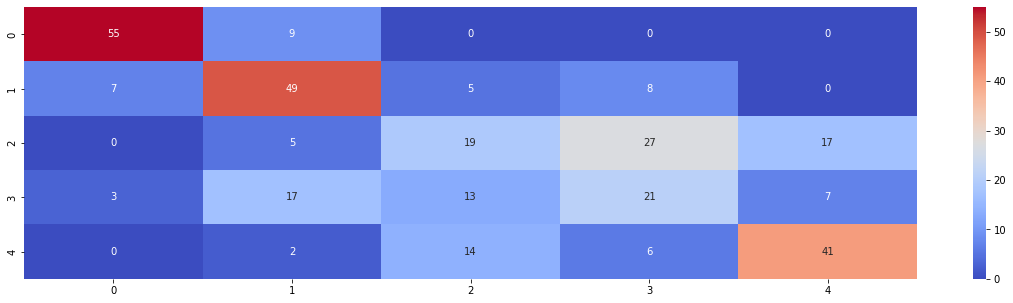

In [144]:
plt.figure(figsize = [20,5])
sns.heatmap(confusion_matrix(y_test,knn_pred),cmap = 'coolwarm', annot = True);

In [145]:
accuracy = accuracy_score(y_test,knn_pred)
precision = precision_score(y_test,knn_pred,average='macro')
recall = recall_score(y_test,knn_pred,average='macro')
f1 = f1_score(y_test,knn_pred,average = 'macro')

print('KNN')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

KNN
The accuracy score is 0.57
The precision score is 0.56
The recall score is 0.57
The f1 score is 0.56


## Voting Classifier Hard Voting

In [146]:
from sklearn.ensemble import VotingClassifier

In [147]:
clf = VotingClassifier(estimators = [('RandomForest',rfc),('KNN',knn)],voting='hard')
clf.fit(X_train,y_train)
voting_pred = clf.predict(X_test)


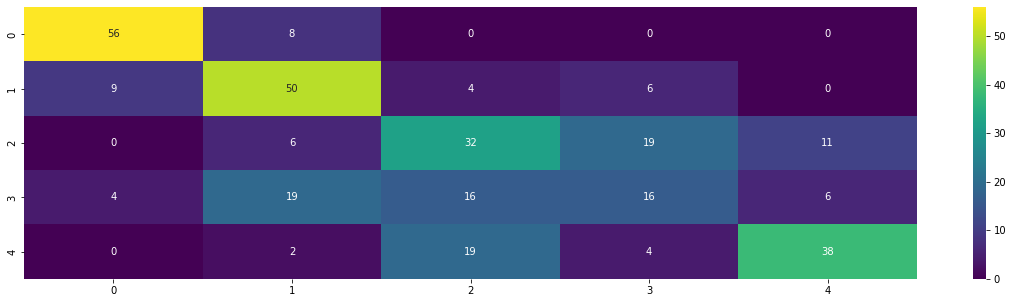

In [148]:
plt.figure(figsize = [20,5])
sns.heatmap(confusion_matrix(y_test,voting_pred),cmap = 'viridis', annot = True);

In [149]:
accuracy = accuracy_score(y_test,voting_pred)
precision = precision_score(y_test,voting_pred,average='macro')
recall = recall_score(y_test,voting_pred,average='macro')
f1 = f1_score(y_test,voting_pred,average = 'macro')

print('VotingClassifier')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

VotingClassifier
The accuracy score is 0.59
The precision score is 0.58
The recall score is 0.59
The f1 score is 0.58


## Voting Classifier Soft Voting

In [150]:
# from sklearn.ensemble import VotingClassifier

In [151]:
clf_s = VotingClassifier(estimators = [('RandomForest',rfc),('KNN',knn)],voting='soft')
clf_s.fit(X_train,y_train)
voting_pred_s = clf.predict(X_test)


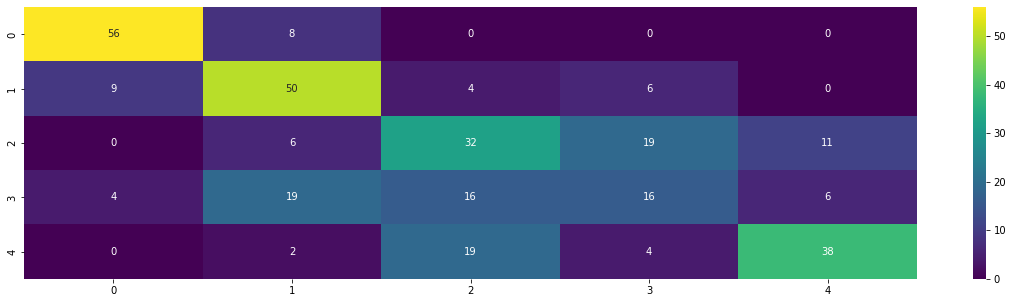

In [152]:
plt.figure(figsize = [20,5])
sns.heatmap(confusion_matrix(y_test,voting_pred_s),cmap = 'viridis', annot = True);

In [153]:
accuracy = accuracy_score(y_test,voting_pred_s)
precision = precision_score(y_test,voting_pred_s,average='macro')
recall = recall_score(y_test,voting_pred_s,average='macro')
f1 = f1_score(y_test,voting_pred_s,average = 'macro')

print('VotingClassifier')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

VotingClassifier
The accuracy score is 0.59
The precision score is 0.58
The recall score is 0.59
The f1 score is 0.58
